# Re-basin ortogonale:una nuova prospettiva sulla connettività lineare tra modelli neurali

Autrice:
- Valeria d'Orsi, 2136945

# ⚙️Imports and utilities

In [108]:
#@title Import dependencies
import math
import torch
import numpy as np
import random
import torch.nn.functional as F
import copy
import pandas as pd
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm
from torch import nn
from torch import optim

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Al fine di effettuare un confronto rigoroso con quanto riportato nell’articolo *Git Re-Basin*, si considerano architetture di tipo Multi-Layer Perceptron (MLP) composte da tre layer nascosti, ciascuno costituito da 512 unità. Tra i layer viene utilizzata la funzione di attivazione ReLU.

In [109]:
class MLPModel_mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 10)

    def forward(self, xb):
        xb=torch.flatten(xb, start_dim=1)
        xb = self.fc1(xb)
        xb = F.relu(xb)

        xb = self.fc2(xb)
        xb = F.relu(xb)

        xb = self.fc3(xb)
        xb = F.relu(xb)

        xb = self.fc4(xb)
        xb = F.log_softmax(xb, dim=-1)

        return xb

model=MLPModel_mnist()

layer_names = ['fc1', 'fc2', 'fc3']  #si esclude fc4 perchè negli algoritmi viene analizzato separatamente
lambdas = np.linspace(0, 1, 22)


In [110]:
import matplotlib.pyplot as plt
def train(model,train_dl,valid_dl):
      loss_func = F.cross_entropy
      epochs = 12
      lr = 0.001
      losses = torch.zeros(epochs)
      val_losses = torch.zeros(epochs)
      opt = optim.Adam(model.parameters(), lr=lr)

      valid_accuracy = torch.zeros(epochs)

      for epoch in range(epochs):
          model.train()
          train_loss = 0
          total = 0
          for xb, yb in train_dl:
              pred = model(xb)
              loss = loss_func(pred, yb)
              loss.backward()
              opt.step()
              opt.zero_grad()
              train_loss += loss.item() * xb.size(0)
              total += xb.size(0)
          losses[epoch] = train_loss / total


          model.eval()
          val_loss = 0
          total = 0
          correct= 0
          with torch.no_grad():
              for xv, yv in valid_dl:
                  outputs = model(xv)
                  val_loss += loss_func(outputs, yv).item() * xv.size(0)
                  predicted = outputs.argmax(dim=1)
                  correct += (predicted == yv).sum().item()
                  total += yv.size(0)
              valid_accuracy[epoch] = correct / total
              val_losses[epoch] = val_loss / total

          if not epoch % 10:
              print(epoch, loss.item())

      plt.figure(figsize=(6, 3))
      plt.plot(valid_accuracy, label='validation', color='red')
      plt.xlabel('epochs')
      plt.ylabel('accuracy')
      plt.xlim(-1, epochs + 1)
      plt.ylim(0.1, 1)
      plt.legend()
      plt.grid(True)
      plt.show()
      plt.figure(figsize=(6, 3))
      plt.plot(losses, color='red', label='train')
      plt.plot(val_losses.detach().numpy(), color='black', label='val')
      plt.xlabel('epochs')
      plt.ylabel('loss')
      plt.grid(True)
      plt.legend()
      plt.show()

      print(f"final validation accuracy: {valid_accuracy[-1]*100:.2f}%")


In [111]:
loss_fn = torch.nn.CrossEntropyLoss()

def evaluate_loss(model, dataloader, loss_fn):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xv, yv in dataloader:
            outputs = model(xv)
            val_loss += loss_fn(outputs, yv).item() * xv.size(0)

            predicted = outputs.argmax(dim=1)
            correct += (predicted == yv).sum().item()
            total += yv.size(0)
    avg_loss = val_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

### DATASET MNIST


In [112]:
from torch.utils.data import random_split, DataLoader

#Si usa il primo seed per allenare il modello A

bs=500
seed = 42
g1 = torch.Generator().manual_seed(seed)

transform = transforms.ToTensor()

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(mnist_train))
valid_size = len(mnist_train) - train_size

train_dataset1, valid_dataset1 = random_split(mnist_train, [train_size, valid_size], generator=g1)

train_loader1 = DataLoader(train_dataset1, batch_size=bs, shuffle=True)
valid_loader1 = DataLoader(valid_dataset1, batch_size=128, shuffle=False)

#Si usa il secondo seed per allenare il modello B

seed = 173
g2 = torch.Generator().manual_seed(seed)


train_dataset2, valid_dataset2 = random_split(mnist_train, [train_size, valid_size], generator=g2)

train_loader2 = DataLoader(train_dataset2, batch_size=bs, shuffle=True)
valid_loader2 = DataLoader(valid_dataset2, batch_size=128, shuffle=False)

#Si usano il terzo e il quarto seed per le fasi di evaluation nelle fasi di interpolazione

seed = 888
g3 = torch.Generator().manual_seed(seed)


train_dataset3, valid_dataset3 = random_split(mnist_train, [train_size, valid_size], generator=g3)

train_loader3 = DataLoader(train_dataset3, batch_size=bs, shuffle=True)
valid_loader3 = DataLoader(valid_dataset3, batch_size=128, shuffle=False)


seed = 512
g4 = torch.Generator().manual_seed(seed)


train_dataset4, valid_dataset4 = random_split(mnist_train, [train_size, valid_size], generator=g4)

train_loader4 = DataLoader(train_dataset4, batch_size=bs, shuffle=True)
valid_loader4 = DataLoader(valid_dataset4, batch_size=128, shuffle=False)





# Training

0 0.21776597201824188
10 0.020122891291975975


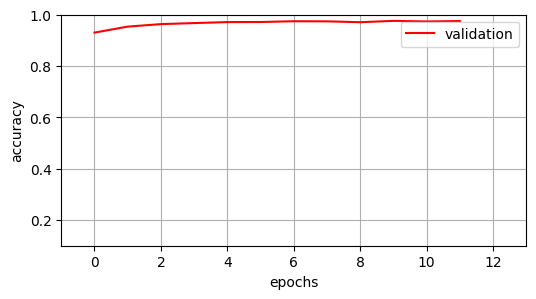

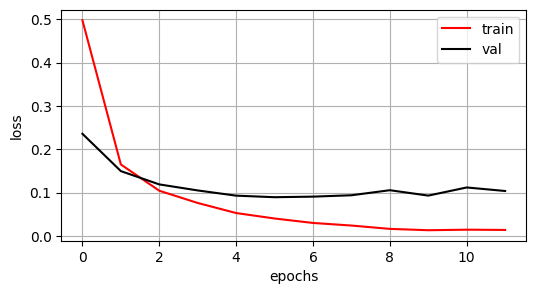

final validation accuracy: 97.54%


In [113]:
model_a = MLPModel_mnist()
train(model_a,train_loader1,valid_loader1)

0 0.1949700117111206
10 0.006802117917686701


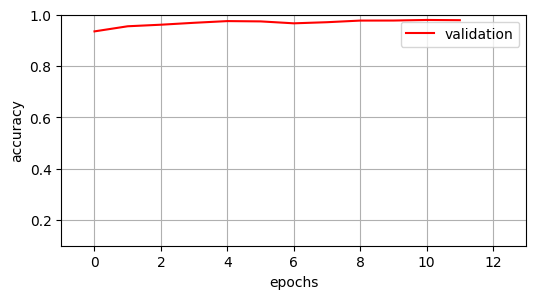

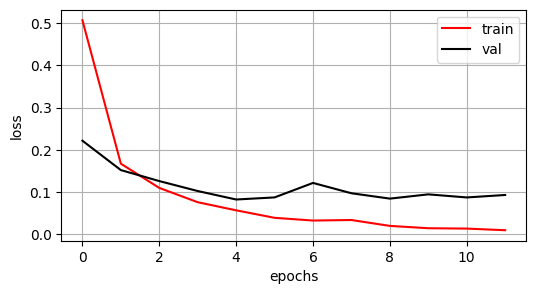

final validation accuracy: 97.87%


In [114]:
model_b = MLPModel_mnist()
train(model_b,train_loader2,valid_loader2)

In [115]:
#funzione per ricavare le attivazioni di un modello
def get_multiple_fc_activations(model, layer_names, dataloader, max_batches=5):
    import gc

    activations_dict = {name: [] for name in layer_names}

    def get_hook(name):
        def hook_fn(module, input, output):
            activations_dict[name].append(output.detach().cpu())
        return hook_fn

    handles = []
    for name, module in model.named_modules():
        if name in layer_names:
            handle = module.register_forward_hook(get_hook(name))
            handles.append(handle)

    model = model.to("cpu")
    model.eval()

    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            if i >= max_batches:
                break
            inputs = inputs.to("cpu")
            model(inputs)


    for handle in handles:
        handle.remove()


    gc.collect()
    torch.cuda.empty_cache()

    Z_dict = {}
    for name, acts in activations_dict.items():
        all_acts = torch.cat(acts, dim=0)
        Z = all_acts.T
        Z_dict[name] = Z

    return Z_dict

# Permutation Methods

Prima di sviluppare le tecniche di allineamento basate su rotazioni, si implementato gli algoritmi di matching tramite permutazioni che rappresentano la baseline del progetto. Per ogni algoritmo si restituisce in output il nuovo modello e un dizionario, che ha come chiave il layer e come valore la trasformazione calcolata per quel layer.

## Activation Matching

Dati due modelli $A$ e $B$, l'activation matching si propone di individuare la matrice di permutazione che ne allinea le attivazioni:
$$ P_\ell  =\arg\min_{P \in S_d} \sum_{i=1}^{n} \left\| Z^{(A)}_{:,i} - P Z^{(B)}_{:,i} \right\|^2$$
La permutazione ottimale si ricava risolvendo un problema di assegnamento lineare, che trova la sua soluzione nell'applicazione dell'algoritmo ungherese.

In [116]:
from scipy.optimize import linear_sum_assignment

def compute_permutation_matrix(Z_A: torch.Tensor, Z_B: torch.Tensor) :
    Z_A_np = Z_A.cpu().numpy()                      #shape(dim output,esempi)
    Z_B_np = Z_B.cpu().numpy()

    d = Z_A_np.shape[0]
    cost_matrix = np.linalg.norm(Z_A_np[:, None, :] - Z_B_np[None, :, :], axis=2)**2

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    P = np.zeros((d, d), dtype=np.float32)
    P[row_ind, col_ind] = 1.0

    return torch.from_numpy(P)


def activation_matching(model_a, model_b, layer_names, valid_dl):
    perm_model = copy.deepcopy(model_b)
    diz_res,diz_perm={},{}
    dizA = get_multiple_fc_activations(model_a, layer_names, valid_dl)
    dizB = get_multiple_fc_activations(model_b, layer_names, valid_dl)

    for n,layer in enumerate(layer_names):
        Z_A = dizA[layer]
        Z_B = dizB[layer]

        Player = compute_permutation_matrix(Z_A, Z_B)
        diz_perm[layer]=Player

        layer_obj = getattr(model_b, layer)
        W = layer_obj.weight.data.clone()
        b = layer_obj.bias.data.clone()

        if n>0:
          W_new = Player @ W @ P_prev.T
        else:
          W_new = Player @ W

        b_new = Player @ b
        P_prev = Player

        layer_perm = getattr(perm_model, layer)
        with torch.no_grad():
            layer_perm.weight.data.copy_(W_new)
            layer_perm.bias.data.copy_(b_new)

    final_layer_name = 'fc4'
    final_layer_model_b = getattr(model_b, final_layer_name)
    W_final = final_layer_model_b.weight.data.clone()
    b_final = final_layer_model_b.bias.data.clone()

    final_layer_perm = getattr(perm_model, final_layer_name)
    with torch.no_grad():
        final_layer_perm.weight.data.copy_(W_final @ P_prev.T)
        final_layer_perm.bias.data.copy_(b_final)

    return perm_model,diz_perm

## Matching weights


Si propongono due implementazioni relative al problema del matching weight, entrambe basate su un algoritmo di tipo coordinate descent e che mirano a trovare la permutazione ottimale minimizzando la distanza euclidea (L2) tra due matrici di pesi $A$ e $B$ del layer $\ell$, dopo aver permutato $B$ secondo una permutazione $\Pi$:


$$ P_\ell  =arg\min_{\Pi \in S_d} \left\| \mathrm{vec}(A) - \mathrm{vec}(\Pi(B)) \right\|^2
$$

Nella prima implementazione si adotta un algoritmo iterativo di tipo greedy in cui, ad ogni iterazione, si considera una singola permutazione associata alle matrici dei pesi di un determinato layer, mentre tutte le altre permutazioni vengono mantenute fisse.

Si costruisce una matrice di similarità tra i pesi del modello di riferimento ($A$) e quelli del secondo modello (già parzialmente permutati), e si risolve un problema di assegnamento lineare (LAP) tramite l’algoritmo ungherese con il fine di trovare la permutazione che massimizza la similarità.




In [117]:
from typing import NamedTuple
from collections import defaultdict

class PermutationSpec(NamedTuple):
    perm_to_axes: dict      #mappa permutazioni a (layer, asse)
    axes_to_perm: dict      #mappa layer a permutazioni


def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
    perm_to_axes = defaultdict(list)
    for layer, axis_perms in axes_to_perm.items():         #axis_perm è una tupla con le permutazioni da attuare per il layer:(perm_riga,perm_colonne)
        for axis, perm in enumerate(axis_perms):
            if perm is not None:
                perm_to_axes[perm].append((layer, axis))
    return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)


def mlp_permutation_spec_torch(num_hidden_layers) -> PermutationSpec:
    assert num_hidden_layers >= 1

    spec = {}
    spec["fc1.weight"] = ("P_1", None)
    spec["fc1.bias"] = ("P_1",None)
    for i in range(2, num_hidden_layers + 1):
        spec[f"fc{i}.weight"] = (f"P_{i}", f"P_{i-1}")
        spec[f"fc{i}.bias"] = (f"P_{i}",None)
    spec[f"fc{num_hidden_layers + 1}.weight"] = (None, f"P_{num_hidden_layers}")
    spec[f"fc{num_hidden_layers + 1}.bias"] = (None,None)

    return permutation_spec_from_axes_to_perm(spec)


def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
    w = params[k]
    for axis, p in enumerate(ps.axes_to_perm[k]):
        if axis == except_axis:
            continue
        if p is not None:
            if axis == 0:
                w = w[perm[p], ...]
            else:
                w = w[:, perm[p], ...]
    return w

def apply_permutation(ps: PermutationSpec, perm, params):
    """Applica le permutazioni `perm` ai parametri `params`."""
    return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}


def weight_matching(rng, ps: PermutationSpec, params_a: dict,params_b: dict, max_iter=100, init_perm=None, silent=False):

    perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}
    if init_perm is None:
        perm = {p: torch.arange(n) for p, n in perm_sizes.items()}
    else:
        perm = init_perm

    perm_names = list(perm.keys())

    for iteration in range(max_iter):
        progress = False
        indices = torch.randperm(len(perm_names), generator=rng)
        perm_names = [perm_names[i] for i in indices]

        for p in perm_names:
            n = perm_sizes[p]
            A = torch.zeros((n, n), dtype=torch.float32)

            for wk, axis in ps.perm_to_axes[p]:
                w_a = params_a[wk]
                w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)

                w_a = w_a.transpose(0, axis).reshape(n, -1)
                w_b = w_b.transpose(0, axis).reshape(n, -1)

                A += w_a @ w_b.T

            '''Risolve problema di assegnamento lineare per massimizzare similarità'''
            A_np = A.detach().numpy()
            ri, ci = linear_sum_assignment(A_np, maximize=True)

            assert np.all(ri == np.arange(n)), "Assertion failed: ri is not equal to np.arange(n)"

            oldL = A[torch.arange(n), perm[p]].sum()
            newL = A[torch.arange(n), torch.tensor(ci)].sum()

            if newL > oldL + 1e-12:
                perm[p] = torch.tensor(ci)
                progress = True

        if not progress:
            break

    return perm

'''perm = {"P_0": tensor([...]), "P_1": tensor([...]),..}'''

def permute_model(model_b,params_b,state_b, ps, perm):
    permuted_params_b = apply_permutation(ps, perm, params_b)
    permuted_state_b = state_b.copy()
    for k in permuted_params_b:
        permuted_state_b[k] = permuted_params_b[k]
    m_perm = copy.deepcopy(model_b)
    m_perm.load_state_dict(permuted_state_b)
    return m_perm

In [118]:
def permutation_matrix(perm_tensor):
    N = perm_tensor.size(0)
    P = torch.zeros(N, N)
    for i in range(N):
        P[i, perm_tensor[i]] = 1
    return P

def create_dict( perm,layer_names=['fc1','fc2','fc3'],):
    if isinstance(perm,dict):
      permutazioni=[permutation_matrix(p) for p in perm.values()]
    else:
      permutazioni=perm
    diz_perm={}
    for i,layer in enumerate(layer_names):
      diz_perm[layer]=permutazioni[i]
    return diz_perm


###  Matching weights: 2ⁿᵈ algorithm


Differentemente dal primo algoritmo, in cui la matrice di similarità viene costruita considerando esclusivamente i pesi di un singolo layer, nel secondo algoritmo la matrice di similarità associata alla permutazione di un layer specifico incorpora sia i pesi di tale layer sia quelli del layer successivo nel seguente modo:
$$M=W_A^{(l)} P_{l-1} W_B^{(l)\top} + W_A^{(l+1)\top} P_{l+1} W_B^{(l+1)}$$

Dando importanza alle interazioni tra layer contigui, il problema di assegnamento lineare, risolto ad ogni iterazione, riflette un allineamento  più globale .

In [119]:
def solve_lap(cost_matrix):
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    return col_ind


def permutation_coordinate_descent(weights_A, weights_B, max_iter=10):
    L = len(weights_A)
    d = weights_A[1].shape[0]

    perms = [torch.eye(d) for _ in range(L - 1)]

    for _ in range(max_iter):
        for l in torch.randperm(L - 1):

            P_l0 = perms[l - 1] if l > 0 else torch.eye(weights_A[0].shape[1])
            P_l1 = perms[l + 1] if l < L - 2 else torch.eye(weights_A[-1].shape[0])
            WA_l = weights_A[l]
            WA_l1 = weights_A[l + 1]
            WB_l = weights_B[l]
            WB_l1 = weights_B[l + 1]

            M = WA_l @ P_l0 @ WB_l.T + WA_l1.T @ P_l1 @ WB_l1
            M_np = M.detach().cpu().numpy()
            perm = solve_lap(M_np)
            perms[l] = permutation_matrix(torch.tensor(perm))

    return perms


def get_weights(model):
    weights = [model.fc1.weight.data.clone(),model.fc2.weight.data.clone(),model.fc3.weight.data.clone(),model.fc4.weight.data.clone()]
    return weights

def get_biases(model):
    biases = [model.fc1.bias.data.clone(),model.fc2.bias.data.clone(),model.fc3.bias.data.clone(),model.fc4.bias.data.clone()]
    return biases


def apply_perm2(model_b, perm, layer_names):
    weighted_model = copy.deepcopy(model_b)

    weights_B = get_weights(model_b)
    biases_B = get_biases(model_b)
    perm = [torch.eye(weights_B[0].shape[1])] + perm + [torch.eye(weights_B[-1].shape[0])]

    for i, layer_name in enumerate(layer_names):
        W_new = perm[i + 1] @ weights_B[i] @ perm[i].T
        b_new = perm[i + 1] @ biases_B[i]
        layer = getattr(weighted_model, layer_name)
        with torch.no_grad():
            layer.weight.copy_(W_new)
            layer.bias.copy_(b_new)

    return weighted_model


def apply_match_weights(model_a,model_b,stringa):
  ps = mlp_permutation_spec_torch(num_hidden_layers=3)

  if stringa=='descent':
    weights_A,weights_B = get_weights(model_a),get_weights(model_b)
    perm=permutation_coordinate_descent(weights_A, weights_B)
    m_weight=apply_perm2(model_b, perm, ['fc1', 'fc2', 'fc3','fc4'])

  else:
    state_b = model_b.state_dict()
    params_b = {k: v for k, v in state_b.items() if 'weight' in k or 'bias' in k}
    state_a = model_a.state_dict()
    params_a = {k: v for k, v in state_a.items() if 'weight' in k or 'bias' in k}
    perm = weight_matching(torch.Generator().manual_seed(111), ps, params_a, params_b, silent=False)
    m_weight=permute_model(model_b,params_b, state_b,ps, perm)
  d_weight=create_dict(perm)

  return m_weight,d_weight




## Learning permutations with a straight-through estimator

Si propone l’implementazione di un ulteriore metodo di allineamento tra due reti neurali, basato sulla tecnica nota come straight-through estimator (STE). Questo metodo, pur risolvendo iterativamente un problema di assegnamento lineare tramite l’algoritmo di weight matching,prima proposto, mira a minimizzare la seguente funzione di perdita:
$$
\min_{\tilde{\theta}_B} \mathcal{L}\left( \frac{1}{2} \left( \theta_A + \operatorname{proj}(\tilde{\theta}_B) \right) \right)
$$
con
$
\operatorname{proj}(\theta) = \arg\max_{\pi} \left( \operatorname{vec}(\theta) \cdot \operatorname{vec}(\pi (\theta_B) \right)$ .

 Dunque si parametrizza il problema in termini di un insieme di pesi $\tilde{\theta}_B$  e della loro proiezione $\pi(\theta_B)$.





In [120]:
def average_models(model_A, model_B):
    avg_model = copy.deepcopy(model_A)
    with torch.no_grad():
        for param_A, param_B, param_avg in zip(model_A.parameters(), model_B.parameters(), avg_model.parameters()):
            param_avg.data.copy_(0.5 * (param_A.data + param_B.data))
    return avg_model


def permute_model(model_b,params_b,state_b, ps, perm):
    permuted_params_b = apply_permutation(ps, perm, params_b)
    permuted_state_b = state_b.copy()
    for k in permuted_params_b:
        permuted_state_b[k] = permuted_params_b[k]
    m_perm = copy.deepcopy(model_b)
    m_perm.load_state_dict(permuted_state_b)
    return m_perm

def straight_through_training(model_a, model_b, data_loader, loss_fn, ps, rng, lr=1e-3, max_iter=50):
    tilde_b = copy.deepcopy(model_a)
    optimizer = torch.optim.SGD(tilde_b.parameters(), lr=lr)

    for step in range(max_iter):
        state_tilde_b = tilde_b.state_dict()
        state_b = model_b.state_dict()

        params_tilde_b = {k: v for k, v in state_tilde_b.items() if 'weight' in k or 'bias' in k}
        params_b = {k: v for k, v in state_b.items() if 'weight' in k or 'bias' in k}
        perm = weight_matching(torch.Generator().manual_seed(111), ps, params_tilde_b, params_b, silent=False)
        permuted_model_b = permute_model(model_b, params_b,state_b, ps, perm)

        permuted_model_b.eval()

        for inputs, targets in data_loader:
            optimizer.zero_grad()
            with torch.no_grad():
                outputs_projB = permuted_model_b(inputs)

            outputs_tildeB = tilde_b(inputs)
            outputs_ste = outputs_projB.detach() + (outputs_tildeB - outputs_projB.detach())

            loss = loss_fn(outputs_ste, targets)

            loss.backward()
            optimizer.step()



        print(f"Step {step + 1}/{max_iter} | Loss midpoint: {loss:.6f}")

    return tilde_b, perm




# 🧬 Interpolazione

Tra gli strumenti per valutare l'efficacia dell'allineamento, fondamentali sono l'interpolazione e il calcolo della Loss Barrier.

## LERP


Tramite Lerp si interpolano due vettori lungo la linea retta che li congiunge
$$ \text{LERP}(\mathbf{v}_1, \mathbf{v}_2; t) = (1 - t) \mathbf{v}_1 + t \mathbf{v}_2 $$
dove:
- $\mathbf{v}_1$ e $\mathbf{v}_2$ sono i due vettori da interpolare,
- $t \in [0, 1]$ è il parametro di interpolazione.

In [121]:
def interpolate_models(model_a, model_b, alpha):
    new_model = copy.deepcopy(model_b)
    with torch.no_grad():
        for (pa, pb, pc) in zip(model_a.parameters(), model_b.parameters(), new_model.parameters()):
            pc.data = (1 - alpha) * pa.data + alpha * pb.data
    return new_model



## SLERP

Tramite Slerp si interpolano due vettori unitari mantenendo la traiettoria su una sfera unitaria.
$$
\text{SLERP}(\mathbf{q}_1, \mathbf{q}_2; t) = \frac{\sin\big((1 - t) \Omega\big)}{\sin(\Omega)} \mathbf{q}_1 + \frac{\sin(t \Omega)}{\sin(\Omega)} \mathbf{q}_2
$$
dove:
- $\mathbf{q}_1$ e $\mathbf{q}_2$ sono i due vettori da interpolare,
- $t \in [0, 1]$ è il parametro di interpolazione,
- $\Omega = \arccos(\mathbf{q}_1 \cdot \mathbf{q}_2)$ è l'angolo tra $\mathbf{q}_1$ e $\mathbf{q}_2$.


In [122]:
'''al fine di interpolare due modelli tramite slerp, le matrici dei pesi vengono trasformate in vettori'''
def slerp_models(model1, model2, t):
    v1 = torch.cat([p.data.flatten() for p in model1.parameters()])
    v2 = torch.cat([p.data.flatten() for p in model2.parameters()])
    v1_copy = v1.clone()
    v2_copy = v2.clone()

    v1_norm = v1_copy / v1_copy.norm()
    v2_norm = v2_copy / v2_copy.norm()

    dot = torch.clamp(torch.dot(v1_norm, v2_norm), -1.0, 1.0)
    theta = torch.acos(dot)
    sin_theta = torch.sin(theta)
    if sin_theta.item() < 1e-6:                          #per evitare divisione per zero
        v_interp = (1.0 - t) * v1 + t * v2
    else:
        v_interp_norm = (torch.sin((1 - t) * theta) / sin_theta) * v1_norm + \
                       (torch.sin(t * theta) / sin_theta) * v2_norm
        norm_interp = (1 - t) * v1.norm() + t * v2.norm()
        v_interp = v_interp_norm * norm_interp
        #interpolo sulla norma perchè i vettori originali non sono unitari, e la loro scala ha un significato.Fare SLERP solo sulla direzione ignorerebbe l’informazione sulla magnitudine.
    model_interp = copy.deepcopy(model1)
    offset = 0
    for p in model_interp.parameters():
        numel = p.numel()
        p.data.copy_(v_interp[offset:offset + numel].view_as(p))
        offset += numel

    return model_interp


## Loss barrier

Dati due modelli $A$ e $B$, la *loss barrier* è definita come
$$
 \max_{\alpha \in [0,1]} \left( \mathcal{L}\big( (1-\alpha) \theta_A +  \alpha\theta_B \big) - \frac{\mathcal{L}(\theta_A) + \mathcal{L}(\theta_B)}{2} \right)
$$


In [123]:

def loss_barrier(model_a,model_b,valid_loader,alphas,loss_fn):
        loss_a, _ = evaluate_loss(model_a, valid_loader, loss_fn)
        loss_b, _ = evaluate_loss(model_b, valid_loader, loss_fn)
        base_loss=(loss_a+loss_b)*0.5
        max_interpolated_loss = -float('inf')
        for alpha in alphas:
                model_interp = interpolate_models(model_a, model_b, alpha)
                model_interp.eval()
                loss_interpolated, _ = evaluate_loss(model_interp, valid_loader, loss_fn)
                barrier = loss_interpolated - base_loss
                max_interpolated_loss = max(max_interpolated_loss, barrier)
        return round(max_interpolated_loss, 4)

#da applicare quando si conoscono già le loss dei modelli interpolati (contenute in val_loss)
def loss_barrier_efficient(val_loss:list):
    base_loss = 0.5 * (val_loss[0] + val_loss[-1])
    return round(max(loss - base_loss for loss in val_loss), 4)




In [124]:
#@title Per un futuro confronto
#si prepara il materiale per realizzare una tabella di confronto tra i vari metodi sui seguenti valori

Loss_barrier,Loss_barrier_slerp,Min_accuracy,Min_accuracy_slerp,Methods_loss_barrier=[],[],[],[],[]
def update_loss(loss,loss_slerp,acc,acc_slerp,stringa):
  Loss_barrier.append(loss)
  Loss_barrier_slerp.append(loss_slerp)
  Min_accuracy.append(min(acc))
  Min_accuracy_slerp.append(min(acc_slerp))
  Methods_loss_barrier.append(stringa)

## Interpolation comparison

In [125]:
#funzioni per interpolare due modelli e plottarne il grafico della validation loss e accuracy, in funzione del parametro lambda

def comparison_naive(model_a,model_b,valid_dl,loss_fn = torch.nn.CrossEntropyLoss(),lambdas = np.linspace(0, 1, 22)):
    val_losses_ab ,acc_ab= [],[]
    for lam in lambdas:
        interpolated = interpolate_models(model_a, model_b, lam)
        loss,acc = evaluate_loss(interpolated, valid_dl, loss_fn)
        acc_ab.append(acc)
        val_losses_ab.append(loss)
    return  val_losses_ab ,acc_ab


def interpolate_slerp_naive(model_a,model_b,valid_dl,loss_fn = torch.nn.CrossEntropyLoss(),lambdas = np.linspace(0, 1, 22)):
    val_losses_ab_slerp ,acc_ab_slerp= [],[]
    for lam in lambdas:
        interpolated = slerp_models(model_a, model_b, lam)
        loss_slerp,acc_slerp = evaluate_loss(interpolated, valid_dl, loss_fn)
        acc_ab_slerp.append(acc_slerp)
        val_losses_ab_slerp.append(loss_slerp)
    return  val_losses_ab_slerp ,acc_ab_slerp



def comparison_interpolation_method(model_a,perm_model,val_losses_ab ,acc_ab,valid_dl,stringa,plot,lambdas = np.linspace(0, 1, 22),loss_fn=torch.nn.CrossEntropyLoss()):
    val_losses_ap ,acc_ap= [],[]
    for lam in lambdas:
        interpolated_p = interpolate_models(model_a, perm_model, lam)
        loss_p,acc_p = evaluate_loss(interpolated_p, valid_dl, loss_fn)
        acc_ap.append(acc_p)
        val_losses_ap.append(loss_p)
    if plot==1:
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        axs[0].plot(lambdas, val_losses_ab, marker='o', label="Naive A ↔ B")
        axs[0].plot(lambdas, val_losses_ap, marker='s', label=stringa)
        axs[0].set_xlabel("λ (interpolation factor)")
        axs[0].set_ylabel("Validation Loss")
        axs[0].set_title("Validation Loss - Interpolation Between Models")
        axs[0].grid(True)
        axs[0].legend()

        axs[1].plot(lambdas, acc_ab, marker='o', label=" Naive A ↔ B")
        axs[1].plot(lambdas, acc_ap, marker='s', label=stringa)
        axs[1].set_xlabel("λ (interpolation factor)")
        axs[1].set_ylabel("Accuracy")
        axs[1].set_title("Accuracy - Interpolation Between Models")
        axs[1].grid(True)
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    return val_losses_ap ,acc_ap



def interpolate_slerp_and_loss_barrier(model_a, reflected_model, val_losses_ab_slerp ,acc_ab_slerp,valid_loader,loss_fn = torch.nn.CrossEntropyLoss(),lambdas = np.linspace(0, 1, 22)):
    val_losses_ar,acc_ar=[],[]

    loss_a, _ = evaluate_loss(model_a, valid_loader, loss_fn)
    loss_b, _ = evaluate_loss(reflected_model, valid_loader, loss_fn)
    base_loss=(loss_a+loss_b)*0.5
    max_interpolated_loss = -float('inf')

    for lam in lambdas:
        interpolated_r = slerp_models(model_a, reflected_model, lam)
        loss_r,acc_r = evaluate_loss(interpolated_r, valid_loader, loss_fn)
        val_losses_ar.append(loss_r)
        acc_ar.append(acc_r)

        barrier = loss_r - base_loss
        max_interpolated_loss = max(max_interpolated_loss, barrier)

    plt.plot(lambdas, val_losses_ab_slerp, marker='o', label="A ↔ B")
    plt.plot(lambdas, val_losses_ar, marker='s', label="A ↔ B allineato")
    plt.xlabel("λ (interpolation factor)")
    plt.ylabel("Validation Loss ")
    plt.title("Validation Loss - SLERP Between Models")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.plot(lambdas, acc_ab_slerp, marker='o', label="A ↔ B")
    plt.plot(lambdas, acc_ar, marker='s', label="A ↔ B allineato")
    plt.xlabel("λ (interpolation factor)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy - SLERP Between Models")
    plt.grid(True)
    plt.legend()
    plt.show()

    return round(max_interpolated_loss, 4),acc_ar







# 📌 Perchè cercare metodi di allineamento che si basano su rotazioni?


L'allineamento di modelli tramite permutazioni si fonda su un concetto semplice: riordinare i neuroni nascosti delle reti neurali in modo da far corrispondere quelli che svolgono funzioni simili. Tuttavia le unità nascoste possono essere orientate in modi diverso, i neuroni possono collaborare in combinazioni diverse e lo spazio latente può essere ruotato.Tutte queste possibilità non vengono coperte dall'applicazione di sole permutazioni.

Le rotazioni, invece,sono in grado di modificare l’orientamento dello spazio senza alterarne la geometria: mantengono le distanze, gli angoli e la lunghezza dei vettori. Questo significa che possono allineare sottospazi funzionalmente equivalenti anche se ruotati o mescolati, offrendo una flessibilità che le permutazioni non possono garantire.

##Possibile limite

### Modelli equifunzionali dopo rotazioni?
E' noto che applicare permutazioni ad un modello,compensandole opportunamente, non modifica la funzionalità del modello permutato. Ciò non vale nel caso in cui si applicano matrici di rotazioni.

Supponiamo di avere un layer $l$ con attivazioni:
 $h^{(l)} = \mathrm{ReLU}(z^{(l)}) = \mathrm{ReLU}(W^{(l)} x^{(l-1)} + b^{(l)})
$
con $W^{(l)}$ matrice dei pesi del layer $l$ , $b^{(l)}$ il bias  e $x^{(l-1)}$ input al layer $l$

Applicando una rotazione ortogonale $R$ alla matrice dei pesi e al bias  si ottengono nuove attivazioni post-ReLU: $\tilde{h}^{(l)} = \mathrm{ReLU}(RW^{(l)} x^{(l-1)}+ R b^{(l)})= \mathrm{ReLU}(R(W^{(l)} x^{(l-1)} + b^{(l)})) = \mathrm{ReLU}(R z^{(l)})
$

Il layer $l+1$ prende in input $h^{(l)}$:$z^{(l+1)} = W^{(l+1)} h^{(l)} + b^{(l+1)}$, ma ora il nuovo input è $\tilde{h}^{(l)}$. Per mantenere la funzionalità del modello si cerca un peso $\tilde{W}^{(l+1)}$ tale che

$$
\tilde{z}^{(l+1)} = \tilde{W}^{(l+1)} \tilde{h}^{(l)} + b^{(l+1)} = W^{(l+1)} h^{(l)} + b^{(l+1)}
$$
Si potrebbe pensare di risolvere il problema compensando il layer: $ \tilde{W}^{(l+1)} = W^{(l+1)} R^\top$ così che

$$
\tilde{z}^{(l+1)} = W^{(l+1)} R^\top \tilde{h}^{(l)} + b^{(l+1)} = W^{(l+1)} R^\top \mathrm{ReLU}(R z^{(l)}) + b^{(l+1)}
$$

Tuttavia la ReLU non è lineare:

$$
R^\top \mathrm{ReLU}(R z^{(l)}) \neq R^\top R  \mathrm{ReLU}(z^{(l)}) = \mathrm{ReLU}(z^{(l)})
$$

Questo implica che: $\tilde{z}^{(l+1)} \neq  z^{(l+1)}$ e che le due reti **non sono funzionalmente equivalenti**, anche se le rotazioni dei pesi vengono compensate.Si osserva empiricamente (nella sezione esperimenti con rotazione) che i risultati ottenuti in termini di allineamento e interpolazione superano le piccole discrepanze introdotte.
Dunque nei seguenti metodi proposti ogni rotazione applicata ad un layer $l$ verrà compensata nel layer successivo, come prima descritto, sebbene si possa non raggiungere un'uguaglianza funzionale del modello di partenza.


# Rotations methods

## SVD weight matching

In [126]:
#applicazione diretta della decomposizione a valori singolari sulle matrici dei pesi

def find_rotation_left(W_a, W_b):
    M = W_a @ W_b.T
    U, _, Vh = torch.linalg.svd(M)
    R = U @ Vh
    return R


def svd_weight_matching(model_a, model_b, layer_names):
    rotated_weight_b = copy.deepcopy(model_b)
    R_prev = None
    diz_rot={}
    for n, layer in enumerate(layer_names):
        W_a = getattr(model_a, layer).weight.data
        W_b = getattr(model_b, layer).weight.data
        b_b = getattr(model_b, layer).bias.data

        if n == 0:
            R= find_rotation_left(W_a, W_b)
            W_new = R @ W_b
            b_new = R @ b_b
        else:
            R= find_rotation_left(W_a, W_b @R_prev.T)
            W_new = R @ W_b @ R_prev.T
            b_new = R @ b_b
        diz_rot[layer]=R
        R_prev = R
        layer_obj = getattr(rotated_weight_b, layer)
        with torch.no_grad():
            layer_obj.weight.copy_(W_new)
            layer_obj.bias.copy_(b_new)

    final_layer_name = 'fc4'
    W_final = getattr(model_b, final_layer_name).weight.data.clone()
    b_final = getattr(model_b, final_layer_name).bias.data.clone()

    with torch.no_grad():

        getattr(rotated_weight_b, final_layer_name).weight.copy_( W_final @ R_prev.T)
        getattr(rotated_weight_b, final_layer_name).bias.copy_(b_final)

    return rotated_weight_b,diz_rot



## Procrustes analysis

### Procrustes su attivazioni

In [127]:
from scipy.linalg import svd
from scipy.linalg import orthogonal_procrustes

#tre implementazioni equivalenti per trovare la matrice di rotazione

def find_ortogonal(Z_A, Z_B):               #consente anche matrici di riflessione
    M = Z_A @ Z_B.T
    U, _, Vt = torch.linalg.svd(M)
    R = U @ Vt
    return R

def find_only_rotation(Z_A, Z_B):           #consente esclusivamente matrici di rotazione e non di riflessione
    M = Z_A @ Z_B.T
    U, _, Vt = torch.linalg.svd(M)
    det = torch.det(U @ Vt)

    D = torch.eye(U.size(0), device=U.device)
    D[-1, -1] = det  # +1 o -1

    R = U @ D @ Vt
    return R


def orthogonal_procrustes_rotate(Z_A, Z_B):     #adopera l'implementazione propria di scipy
    Z_A_T = Z_A.T.numpy()
    Z_B_T = Z_B.T.numpy()
    R, _ = orthogonal_procrustes(Z_B_T, Z_A_T)
    R=torch.from_numpy(R.T).float()
    return R


def rotate_activations_procrustes(model_a, model_b, layer_names, dataloader,numero):
    rotated_model = copy.deepcopy(model_b)
    R_dict={}
    err_pre,err_post,err_relu=[],[],[]
    dizA =get_multiple_fc_activations(model_a, layer_names, dataloader, max_batches=5)   # shape: (n neuroni, esempi)
    dizB = get_multiple_fc_activations(model_b, layer_names,dataloader, max_batches=5)
    for n,layer in enumerate(layer_names):
        Z_A = dizA[layer]
        Z_B = dizB[layer]
        if numero==1:
          R=orthogonal_procrustes_rotate(Z_A, Z_B)
        elif numero==0:
          R=find_only_rotation(Z_A, Z_B)
        else:
          R=find_ortogonal(Z_A,Z_B)
        layer_obj = getattr(model_b, layer)
        W = layer_obj.weight.data.clone()
        b = layer_obj.bias.data.clone()
        if n>0:
          W_new =  R @ W @ R_prev.T
        else:
          W_new = R @ W

        b_new = R@ b
        R_dict[layer]=R
        R_prev = R

        layer_rotated = getattr(rotated_model, layer)
        with torch.no_grad():
            layer_rotated.weight.data.copy_(W_new)
            layer_rotated.bias.data.copy_(b_new)
    final_layer_name = 'fc4'
    final_layer_model_b = getattr(model_b, final_layer_name)
    W_final = final_layer_model_b.weight.data.clone()
    b_final = final_layer_model_b.bias.data.clone()

    final_layer_rotated = getattr(rotated_model, final_layer_name)
    with torch.no_grad():
        final_layer_rotated.weight.data.copy_(W_final @ R_prev.T)
        final_layer_rotated.bias.data.copy_(b_final)

    return rotated_model,R_dict






### Procrustes pesi

In [128]:
from typing import NamedTuple
from collections import defaultdict
from scipy.optimize import linear_sum_assignment

#Procruste applicato alla matrice di correlazione lineare

class RotationSpec(NamedTuple):
    rot_to_axes: dict
    axes_to_rot: dict


def rotation_spec_from_axes_to_rot(axes_to_rot: dict) -> RotationSpec:
    rot_to_axes = defaultdict(list)
    for layer, rotations in axes_to_rot.items():        #rotations è una tupla con le rotazioni da attuare per il layer:(rot sx=0, rot dx=1)
        for lato, rotation in enumerate(rotations):
            if rotation is not None:
                rot_to_axes[rotation].append((layer, lato))
    return RotationSpec(rot_to_axes=dict(rot_to_axes), axes_to_rot=axes_to_rot)


def mlp_rotation_spec_torch(num_hidden_layers: int) -> RotationSpec:
    assert num_hidden_layers >= 1

    spec = {}
    spec["fc1.weight"] = ("R_1", None)
    for i in range(2, num_hidden_layers + 1):
        spec[f"fc{i}.weight"] = (f"R_{i}", f"R_{i-1}")
    spec[f"fc{num_hidden_layers + 1}.weight"] = (None, f"R_{num_hidden_layers}")

    return rotation_spec_from_axes_to_rot(spec)


def get_rotated_param(rs: RotationSpec, rot, k: str, params, except_axis=None):
    w = params[k]
    for axis, r in enumerate(rs.axes_to_rot[k]):
        if axis == except_axis:
            continue
        if r is not None:
            R=rot[r].float()
            if axis == 0:
                w = R @ w
            else:
                w = w @ R.T
    return w


def apply_rotations(rs: RotationSpec, rot, params):
    return {k: get_rotated_param(rs, rot, k, params) for k in params.keys()}


def weight_matching_procrustes(rng,rs: RotationSpec,params_a: dict,params_b: dict,max_iter=100,init_rot=None,silent=False):

    rot_sizes = {r: params_a[axes[0][0]].shape[axes[0][1]] for r, axes in rs.rot_to_axes.items()}

    if init_rot is None:
        rot= {r: torch.eye(n) for r, n in rot_sizes.items()}
    else:
        rot = init_rot

    rot_names = list(rot.keys())

    for iteration in range(max_iter):
        progress = False

        for r in rot_names:
            n = rot[r].shape[0]
            A = torch.zeros((n, n), dtype=torch.float32)

            for wk, axis in rs.rot_to_axes[r]:
                w_a = params_a[wk]
                w_b = get_rotated_param(rs, rot, wk, params_b, except_axis=axis)

                w_a = w_a.transpose(0, axis).reshape(n, -1)
                w_b = w_b.transpose(0, axis).reshape(n, -1)

                A += w_a @ w_b.T

            U, _, Vt = torch.linalg.svd(A)
            R_new = U @ Vt
            oldL = torch.sum(rot[r] * A)
            newL = torch.sum(R_new * A)

            if newL > oldL + 1e-6:
                rot[r] = R_new
                progress = True

        if not progress:
            break

    return rot



def rotate_model(model_b,params_b,state_b, ps, perm):
    rotated_params_b = apply_rotations(ps, perm, params_b)
    rotated_state_b = state_b.copy()
    for k in rotated_params_b:
        rotated_state_b[k] = rotated_params_b[k]
    m_rotated = copy.deepcopy(model_b)
    m_rotated.load_state_dict(rotated_state_b)
    return m_rotated

def create_dict_pro( rotations,layer_names=['fc1','fc2','fc3'],):
    rot=[r for r in rotations.values()]
    diz_rot={}
    for i,layer in enumerate(layer_names):
      diz_rot[layer]=rot[i]
    return diz_rot


In [129]:
#Risoluzione iterativa del problema di Procruste definito con le matrici dei pesi

def procrustes_on_layer(params_a, params_b, rot, layer, tol=1e-6):
    W_a = params_a[f'fc{layer}.weight']
    W_b = params_b[f'fc{layer}.weight']

    if layer == 1:
        Q_prev = torch.eye(W_a.shape[1], device=W_a.device, dtype=W_a.dtype)
    else:
        Q_prev = rot[f'R_{layer - 1}']

    M = W_a @ Q_prev @ W_b.T
    U, _, Vt = torch.linalg.svd(M)
    R_new = U @ Vt

    old_R = rot.get(f'R_{layer}', torch.eye(W_a.shape[0], device=W_a.device, dtype=W_a.dtype))
    old_sim = torch.sum(old_R * M)
    new_sim = torch.sum(R_new * M)

    if new_sim > old_sim + tol:
        return R_new
    else:
        return old_R


def weight_matching_procrustes_layer(rs, params_a, params_b, max_iter=100, init_rot=None, tol=1e-6):
    rot_sizes = {
        r: params_a[axes[0][0]].shape[axes[0][1]]
        for r, axes in rs.rot_to_axes.items()
    }

    if init_rot is None:
        rot = {r: torch.eye(n, device=params_a[next(iter(params_a))].device, dtype=params_a[next(iter(params_a))].dtype) for r, n in rot_sizes.items()}
    else:
        rot = init_rot

    for _ in range(max_iter):
        converged = True
        rng = random.Random(48)
        layers = list(range(1, 4))
        rng.shuffle(layers)
        for l in layers:
            R_old = rot[f'R_{l}']
            R_new = procrustes_on_layer(params_a, params_b, rot, l, tol=tol)
            if not torch.allclose(R_old, R_new, atol=tol):
                converged = False
            rot[f'R_{l}'] = R_new
        if converged:
            break

    return rot



def apply_pro_weight(model_a,model_b,stringa):
    state_b = model_b.state_dict()
    params_b = {k: v for k, v in state_b.items() if 'weight' in k }
    state_a = model_a.state_dict()
    params_a = {k: v for k, v in state_a.items() if 'weight' in k }

    rs = mlp_rotation_spec_torch(num_hidden_layers=3)

    if stringa=='layer':
      rot = weight_matching_procrustes_layer(rs, params_a, params_b)
    else:
      rot= weight_matching_procrustes(torch.Generator().manual_seed(3), rs, params_a, params_b, silent=False)
    diz_r=create_dict_pro(rot)
    m_pro_weight=rotate_model(model_b,params_b, state_b,rs, rot)

    return m_pro_weight,diz_r


## Stiefel optimization

### Naive optimization

In [130]:
#Implementazione dell'ottimizzazione su varietà di Stiefel senza la trasformazione di Cayley

def project_to_tangent(Q, G):
    sym_part = (Q.T @ G + G.T @ Q) / 2
    return G - Q @ sym_part

def stiefel_retraction(Q):
    Q_new, R = torch.linalg.qr(Q)
    diag = torch.diag(R)
    sign = diag.sign()
    Q_new *= sign
    return Q_new

def loss_align(Q, W1, W2):
    W2_transformed = Q @ W2
    return torch.norm(W1 - W2_transformed, p='fro') ** 2

def stiefel_optimization(W1, W2, lr=0.1, n_steps=200):
    d = W1.shape[0]
    R = torch.linalg.qr(torch.randn(d, d))[0]
    R = R.requires_grad_(True)

    for _ in range(n_steps):
        loss = loss_align(R, W1, W2)
        loss.backward()

        with torch.no_grad():
            G = R.grad
            G_tangent = project_to_tangent(R, G)
            R_new = R - lr * G_tangent
            epsilon = 1e-6
            noise = epsilon * torch.randn_like(R_new)
            R_new = R_new + noise
            R_new = stiefel_retraction(R_new)

        R.grad=None
        R = R_new.detach().requires_grad_(True)

    return R.detach()


def stiefel_naive2(model_a, model_b, layer_names,valid_dl):
    rotated_weight_b = copy.deepcopy(model_b)
    diz={}
    for n,layer in enumerate(layer_names):
        W_a = getattr(model_a, layer).weight.detach().clone()
        W_b = getattr(model_b, layer).weight.detach().clone()
        b_b = getattr(model_b, layer).bias.detach().clone()
        if n == 0:
            R= stiefel_optimization(W_a,W_b)
            W_new = R @ W_b
        else:
            R= stiefel_optimization(W_a,W_b @ R_prev.T)
            W_new = R @ W_b @ R_prev.T
        b_new = R @ b_b
        R_prev = R
        diz[layer]=R
        layer_obj = getattr(rotated_weight_b, layer)
        with torch.no_grad():
            layer_obj.weight.copy_(W_new)
            layer_obj.bias.copy_(b_new)
    final_layer_name = 'fc4'
    W_final = getattr(model_b, final_layer_name).weight.clone()
    b_final = getattr(model_b, final_layer_name).bias.clone()

    with torch.no_grad():
        getattr(rotated_weight_b, final_layer_name).weight.copy_( W_final @ R_prev.T)
        getattr(rotated_weight_b, final_layer_name).bias.copy_(b_final)

    return rotated_weight_b,diz

### Cayley transformation

In [131]:

class CayleyOptimizer(nn.Module):
    def __init__(self, A, B, max_iter=50, tol=1e-6, verbose=True):
        super().__init__()
        self.A = A
        self.B = B
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose


        X = A @ B.T
        X, _ = torch.linalg.qr(X)
        self.register_buffer('X', X)

    def skew_symmetric_W(self, G, X):
        return G @ X.T - X @ G.T

    def cayley_transform(self, X, G, tau):
        W = self.skew_symmetric_W(G, X)
        n = W.shape[0]
        I = torch.eye(n, device=X.device, dtype=X.dtype)
        M = I + (tau / 2) * W
        C = torch.linalg.solve(M, I - (tau / 2) * W)
        return C @ X, torch.linalg.inv(M)

    def f(self, X):
        return torch.norm(self.A - X @ self.B, p='fro')**2

    def grad_f(self, X):
        return -2 * (self.A - X @ self.B) @ self.B.T

    def cayley_search(self, X, G, tau_init=10.0, rho1=1e-4, rho2=0.9, max_iter=20):
        n = X.shape[0]
        I = torch.eye(n, device=X.device)
        tau = tau_init
        FX0 = self.f(X)
        W = self.skew_symmetric_W(G, X)
        F0_prime = torch.trace(G.T @ (-W @ X))

        for _ in range(max_iter):
            Y_tau, M_inv = self.cayley_transform(X, G, tau)
            Y_prime = -M_inv @ W @ ((X + Y_tau) / 2)

            F_Y = self.f(Y_tau)
            F_tau_prime = torch.trace(G.T @ Y_prime)

            if (F_Y <= FX0 + rho1 * tau * F0_prime) and (F_tau_prime >= rho2 * F0_prime):
                return Y_tau, tau

            tau /= 2.0

        return Y_tau, tau

    def forward(self):
        X = self.X
        for k in range(self.max_iter):
            G = self.grad_f(X)
            grad_norm = torch.norm(G)
            if grad_norm < self.tol:
                if self.verbose:
                    print(f"Convergenza raggiunta a iterazione {k}, ||G|| = {grad_norm:.2e}")
                break

            X_new, tau = self.cayley_search(X, G)

            if self.verbose and k % 10 == 0:
                loss = self.f(X)


            X = X_new

        self.X = X
        return X

def adjust(R,epsilon = 1e-6 ):
    noise = epsilon * torch.randn_like(R)
    R = R + noise
    U, _, Vt = torch.linalg.svd(R)
    R = U @ Vt
    return R


def stiefel_cayley(model_a, model_b, layer_names):
    stiefel_model = copy.deepcopy(model_b)
    R_prev = None
    diz={}
    for n, layer in enumerate(layer_names):
        W_a = getattr(model_a, layer).weight.data
        W_b = getattr(model_b, layer).weight.data
        b_b = getattr(model_b, layer).bias.data
        if n == 0:
            cayley_opt = CayleyOptimizer(W_a, W_b, max_iter=50)
            R = cayley_opt()
            if not torch.allclose(R @ R.T, torch.eye(R.shape[0], device=R.device), atol=1e-5):
                R = adjust(R)
            W_new = R @ W_b
            b_new = R @ b_b
        else:
            cayley_opt = CayleyOptimizer(W_a, W_b @ R_prev.T, max_iter=50)
            R = cayley_opt()
            if not torch.allclose(R @ R.T, torch.eye(R.shape[0], device=R.device), atol=1e-5):
                R = adjust(R)
            W_new = R @ W_b @ R_prev.T
            b_new = R @ b_b
        diz[layer]=R
        R_prev = R

        layer_obj = getattr(stiefel_model, layer)
        with torch.no_grad():
            layer_obj.weight.copy_(W_new)
            layer_obj.bias.copy_(b_new)

    final_layer_name = 'fc4'
    W_final = getattr(model_b, final_layer_name).weight.data.clone()
    b_final = getattr(model_b, final_layer_name).bias.data.clone()

    with torch.no_grad():
        getattr(stiefel_model, final_layer_name).weight.copy_(W_final @ R_prev.T)
        getattr(stiefel_model, final_layer_name).bias.copy_(b_final)

    return stiefel_model,diz


# Valori naive

In [132]:
val_naive,acc_naive=comparison_naive(model_a,model_b,valid_loader4)
loss_naive=loss_barrier_efficient(val_naive)


In [133]:
val_naive_slerp,acc_naive_slerp=interpolate_slerp_naive(model_a,model_b,valid_loader4)
loss_naive_slerp=loss_barrier_efficient(val_naive_slerp)
update_loss(loss_naive,loss_naive_slerp,acc_naive,acc_naive_slerp,'naive')

# Esperimenti con permutazioni

Si applicano gli algoritmi prima citati, plottando per ciascuno di essi l'interpolazione SLERP, che si rivela meno efficace in caso di permutazioni, e confrontando poi in unico grafico le interpolazioni LERP, che si rivelano, come aspettato, efficaci, con bassi valori della loss barrier.

## Matching activations

Per leggibilità si decide di indicare con m iniziale i modelli,d iniziale i dizionari

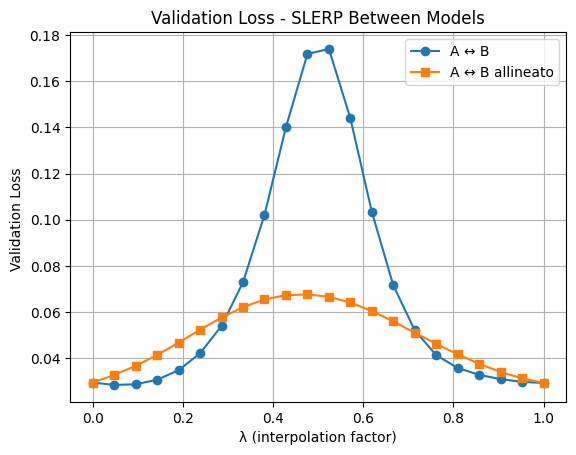

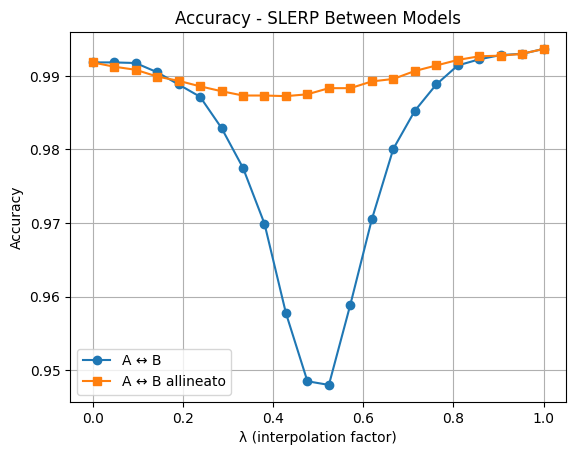

In [134]:
m_act_match,d_act_match=activation_matching(model_a, model_b, layer_names, valid_loader3)
loss_act_match=loss_barrier(model_a,m_act_match,valid_loader4,lambdas,loss_fn)
val_act_match,acc_act_match=comparison_interpolation_method(model_a,m_act_match,val_naive,acc_naive,valid_loader4,'Activation matching',0)
loss_act_match_slerp,acc_act_match_slerp=interpolate_slerp_and_loss_barrier(model_a, m_act_match, val_naive_slerp,acc_naive_slerp,valid_loader4)
update_loss(loss_act_match,loss_act_match_slerp,acc_act_match,acc_act_match_slerp,'Activation matching')

## Matching weights


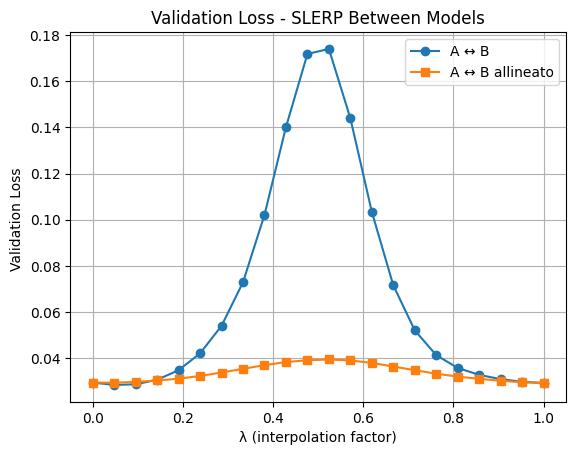

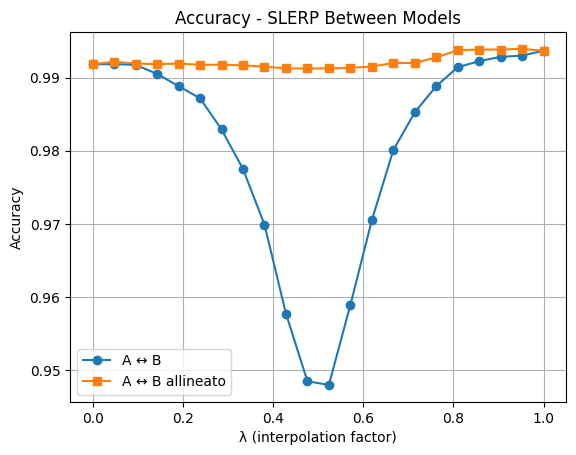

In [135]:
m_weight_match1,d_weight_match1=apply_match_weights(model_a,model_b,'not_descent')
loss_weight_match1=loss_barrier(model_a,m_weight_match1,valid_loader4,lambdas,loss_fn)
val_weight_match1,acc_weight_match1=comparison_interpolation_method(model_a,m_weight_match1,val_naive,acc_naive,valid_loader4,'Weight matching1',0)
loss_weight_match1_slerp,acc_weight_match1_slerp=interpolate_slerp_and_loss_barrier(model_a, m_weight_match1, val_naive_slerp,acc_naive_slerp,valid_loader4)
update_loss(loss_weight_match1,loss_weight_match1_slerp,acc_weight_match1,acc_weight_match1_slerp,'Weight matching')

###  Matching weights: 2ⁿᵈ algorithm


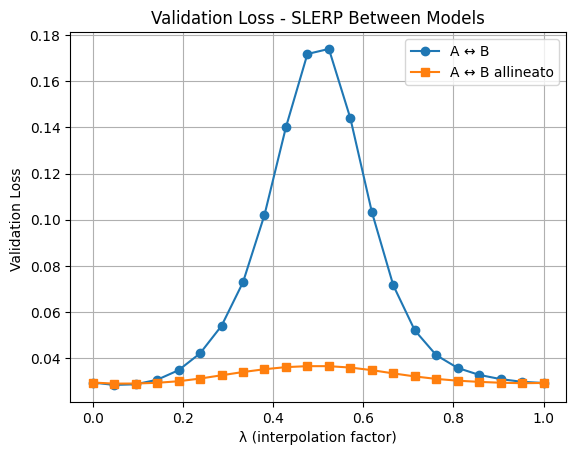

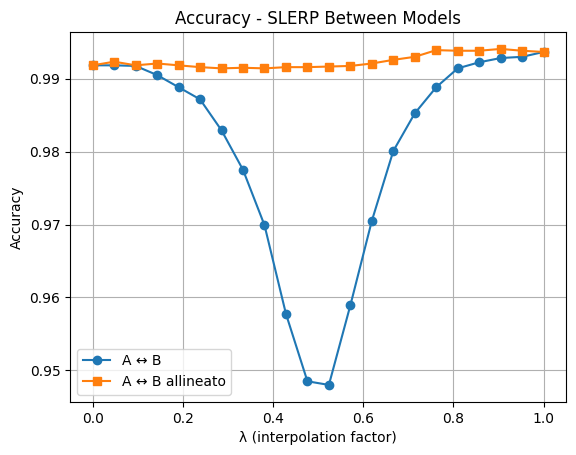

In [136]:
m_weight_match2,d_weight_match2=apply_match_weights(model_a,model_b,'descent')
loss_weight_match2=loss_barrier(model_a,m_weight_match2,valid_loader4,lambdas,loss_fn)
val_weight_match2,acc_weight_match2=comparison_interpolation_method(model_a,m_weight_match2,val_naive,acc_naive,valid_loader4,'Weight matching2',0)
loss_weight_match2_slerp,acc_weight_match2_slerp=interpolate_slerp_and_loss_barrier(model_a, m_weight_match2, val_naive_slerp,acc_naive_slerp,valid_loader4)
update_loss(loss_weight_match2,loss_weight_match2_slerp,acc_weight_match2,acc_weight_match2_slerp,'Weight matching2')

Considerando il medesimo comportamento di m_weight_match1 e m_weight_match2, nel corso del nootebook si userà esclusivamente m_weight_match1

## Learning permutations with a straight-through estimator

In [137]:
ps_ste = mlp_permutation_spec_torch(num_hidden_layers=3)
m_ste,perm_ste=straight_through_training(model_a, model_b, train_loader3, loss_fn, ps_ste, torch.Generator().manual_seed(111), lr=1e-3, max_iter=20)
d_ste=create_dict(perm_ste)


Step 1/20 | Loss midpoint: 0.027651
Step 2/20 | Loss midpoint: 0.029476
Step 3/20 | Loss midpoint: 0.007717
Step 4/20 | Loss midpoint: 0.004551
Step 5/20 | Loss midpoint: 0.022541
Step 6/20 | Loss midpoint: 0.022777
Step 7/20 | Loss midpoint: 0.015974
Step 8/20 | Loss midpoint: 0.007249
Step 9/20 | Loss midpoint: 0.007675
Step 10/20 | Loss midpoint: 0.041435
Step 11/20 | Loss midpoint: 0.050585
Step 12/20 | Loss midpoint: 0.050412
Step 13/20 | Loss midpoint: 0.027513
Step 14/20 | Loss midpoint: 0.033438
Step 15/20 | Loss midpoint: 0.036782
Step 16/20 | Loss midpoint: 0.066666
Step 17/20 | Loss midpoint: 0.018844
Step 18/20 | Loss midpoint: 0.003305
Step 19/20 | Loss midpoint: 0.011923
Step 20/20 | Loss midpoint: 0.003416


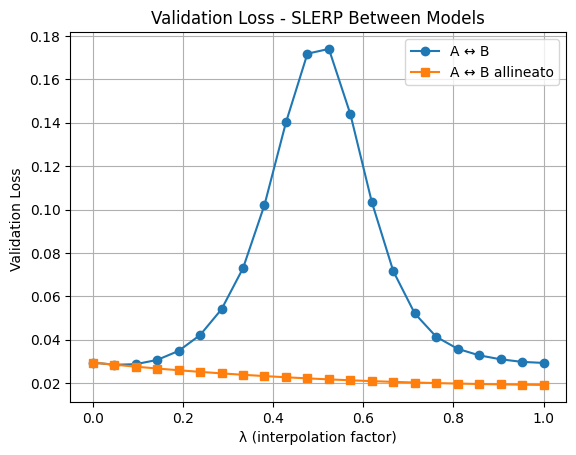

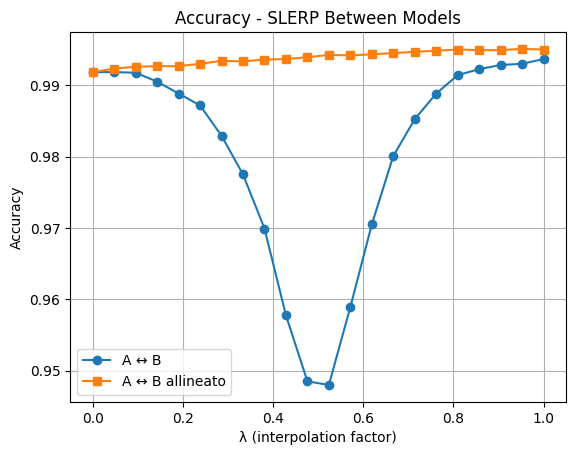

In [138]:
val_ste,acc_ste=comparison_interpolation_method(model_a,m_ste,val_naive,acc_naive,valid_loader4, 'STE matching',0)
loss_ste=loss_barrier(model_a,m_ste,valid_loader4,lambdas,loss_fn)
loss_ste_slerp,acc_ste_slerp=interpolate_slerp_and_loss_barrier(model_a, m_ste, val_naive_slerp,acc_naive_slerp,valid_loader4)
update_loss(loss_ste,loss_ste_slerp,acc_ste,acc_ste_slerp,'Ste')


### Analisi comparativa dei Permutation Methods


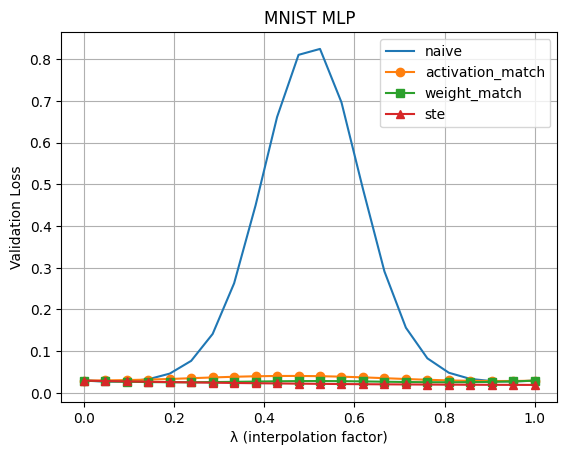

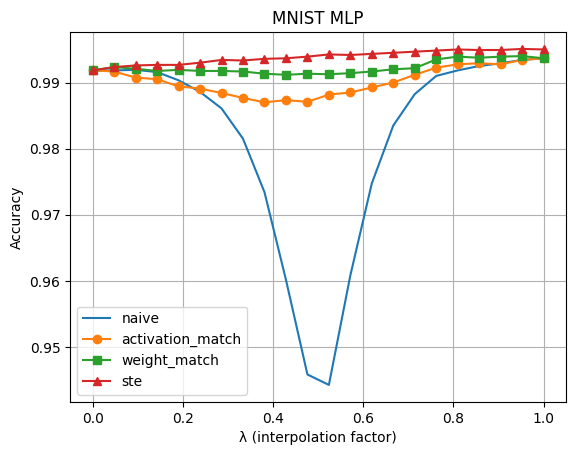

In [139]:
#Confronto Permutation method
plt.plot(lambdas, val_naive, label='naive')
plt.plot(lambdas, val_act_match, marker='o', label='activation_match')
plt.plot(lambdas, val_weight_match1, marker='s', label='weight_match')
plt.plot(lambdas, val_ste, marker='^', label='ste')

plt.xlabel('λ (interpolation factor)')
plt.ylabel('Validation Loss')
plt.title('MNIST MLP')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(lambdas, acc_naive, label='naive')
plt.plot(lambdas, acc_act_match, marker='o', label='activation_match')
plt.plot(lambdas, acc_weight_match1, marker='s', label='weight_match')
plt.plot(lambdas, acc_ste, marker='^', label='ste')

plt.xlabel('λ (interpolation factor)')
plt.ylabel('Accuracy')
plt.title('MNIST MLP')
plt.grid(True)
plt.legend()
plt.show()


# Rotazione esperimenti

Per gli eseprimenti basati su allineamento con rotazione si plottano, per ogni algoritmo, la validation loss e l'accuracy delle interpolazioni sia mediante LERP che con SLERP

## SVD esperimenti

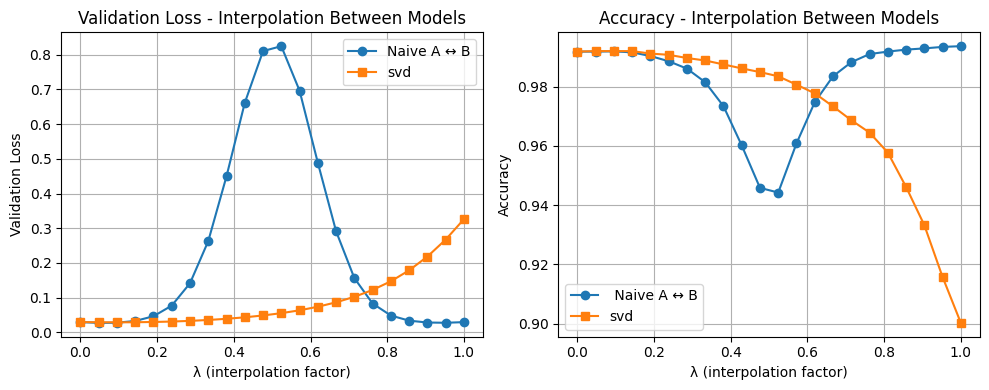

In [140]:
m_svd,d_svd=svd_weight_matching(model_a, model_b, layer_names)
val_svd,acc_svd=comparison_interpolation_method(model_a,m_svd,val_naive,acc_naive,valid_loader4,'svd',1)
loss_svd=loss_barrier_efficient(val_svd)


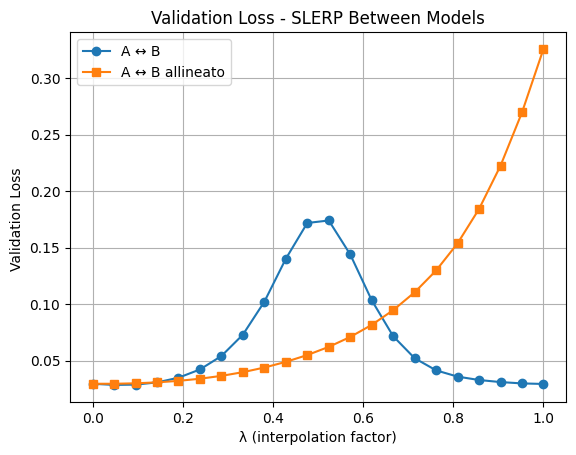

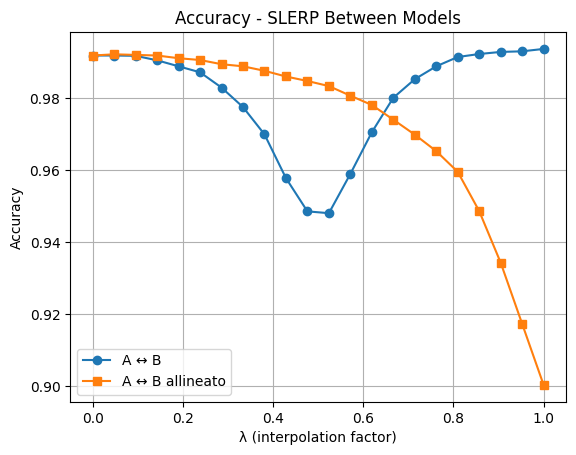

In [141]:
loss_svd_slerp,acc_svd_slerp=interpolate_slerp_and_loss_barrier(model_a,m_svd, val_naive_slerp,acc_naive_slerp,valid_loader4)
update_loss(loss_svd,loss_svd_slerp,acc_svd,acc_svd_slerp,'SVD matching')

## Stiefel esperimenti

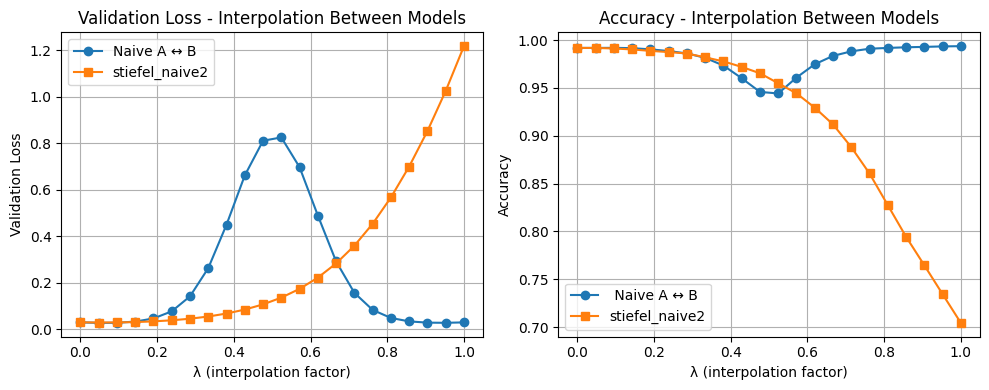

In [142]:
m_stiefel_naive2,d_stiefel_naive2=stiefel_naive2(model_a, model_b, layer_names,valid_loader3)
val_stiefel_naive2,acc_stiefel_naive2=comparison_interpolation_method(model_a,m_stiefel_naive2,val_naive,acc_naive,valid_loader4,'stiefel_naive2',1)
loss_stiefel_naive2=loss_barrier_efficient(val_stiefel_naive2)

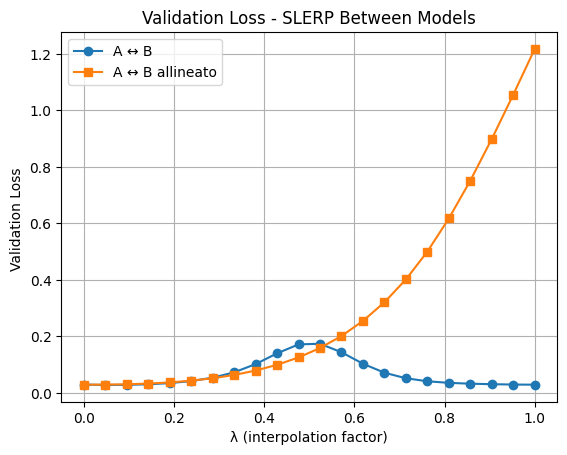

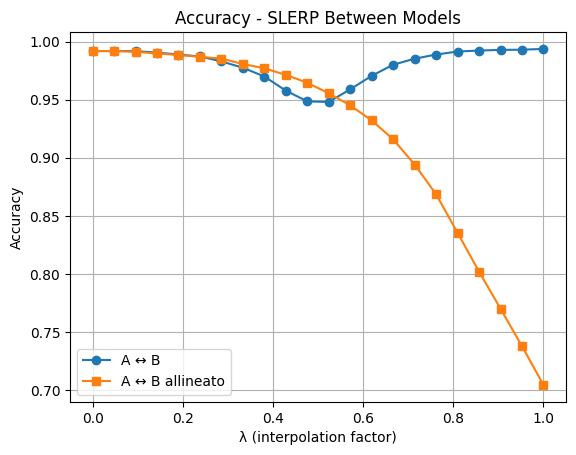

In [143]:
loss_stiefel_naive2_slerp,acc_stiefel_naive2_slerp=interpolate_slerp_and_loss_barrier(model_a,m_stiefel_naive2, val_naive_slerp,acc_naive_slerp,valid_loader4)
update_loss(loss_stiefel_naive2,loss_stiefel_naive2_slerp,acc_stiefel_naive2,acc_stiefel_naive2_slerp,'Stiefel Naive2')

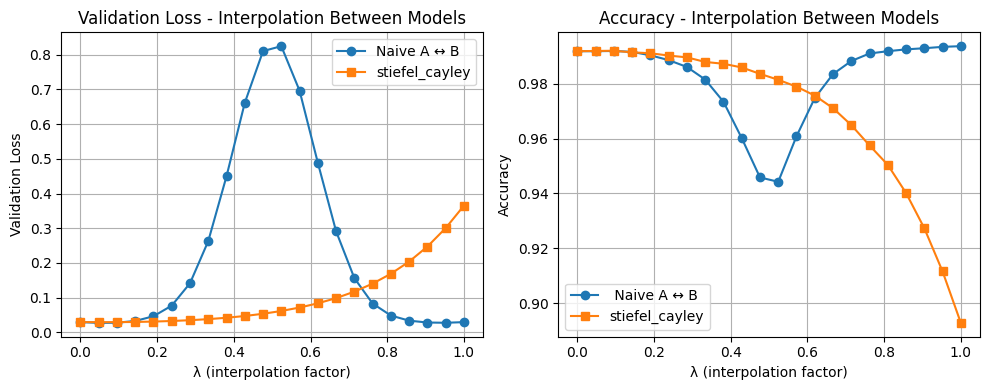

In [144]:
m_stiefel_cayley,d_stiefel_cayley=stiefel_cayley(model_a, model_b, layer_names)
val_stiefel_cayley,acc_stiefel_cayley=comparison_interpolation_method(model_a,m_stiefel_cayley,val_naive,acc_naive,valid_loader4,'stiefel_cayley',1)
loss_stiefel_cayley=loss_barrier_efficient(val_stiefel_cayley)


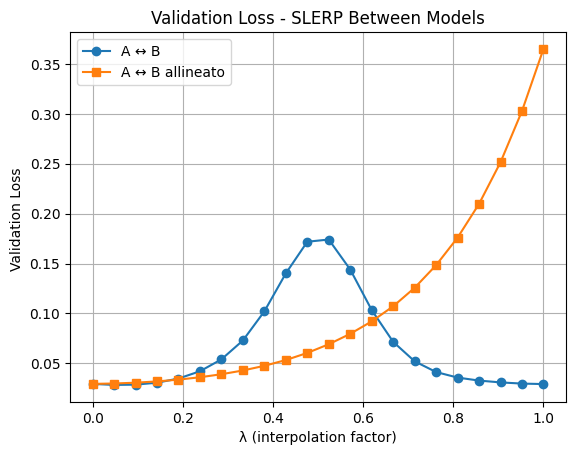

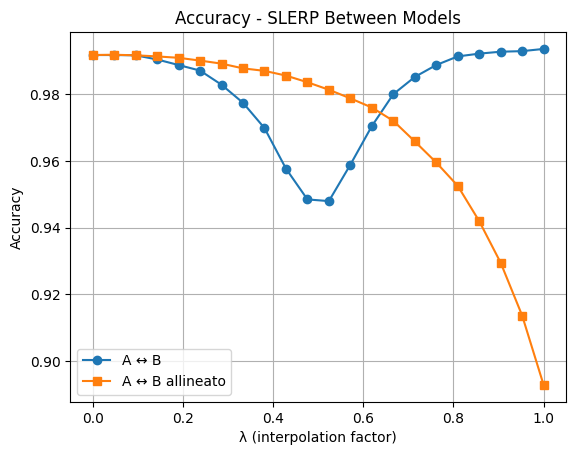

In [145]:
loss_stiefel_cayley_slerp,acc_stiefel_cayley_slerp=interpolate_slerp_and_loss_barrier(model_a,m_stiefel_cayley, val_naive_slerp,acc_naive_slerp,valid_loader4)
update_loss(loss_stiefel_cayley,loss_stiefel_cayley_slerp,acc_stiefel_cayley,acc_stiefel_cayley_slerp,'Stiefel Cayley')

Nel corso del notebook si adopererà m_stiefel_cayley perchè più efficace di m_stiefel_naive2

## Procrustes esperimenti

### Procrustes su attivazioni

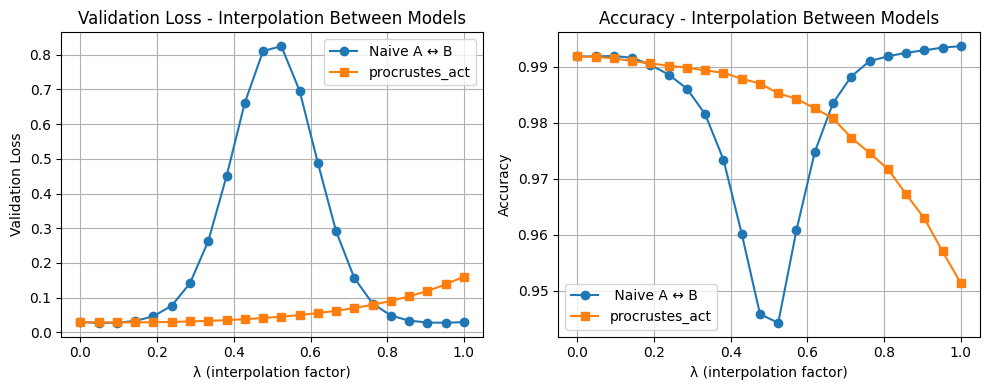

In [147]:
m_pro_act0,d_pro_act0=rotate_activations_procrustes(model_a, model_b, layer_names, valid_loader3,0)
val_pro_act0,acc_pro_act0=comparison_interpolation_method(model_a,m_pro_act0,val_naive,acc_naive,valid_loader4,'procrustes_act',0)
m_pro_act1,d_pro_act1=rotate_activations_procrustes(model_a, model_b, layer_names, valid_loader3,1)
val_pro_act,acc_pro_act=comparison_interpolation_method(model_a,m_pro_act1,val_naive,acc_naive,valid_loader4,'procrustes_act',1)
loss_pro_act=loss_barrier_efficient(val_pro_act)

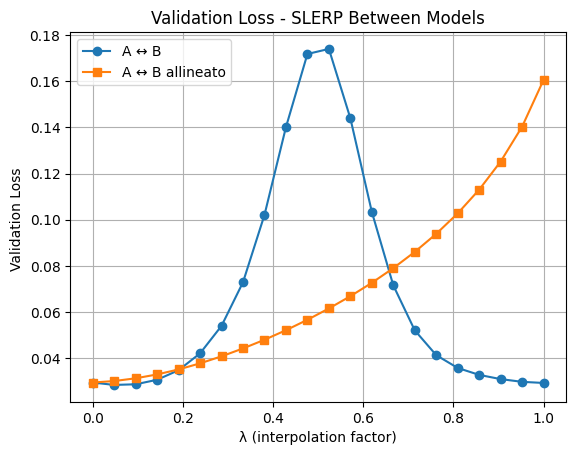

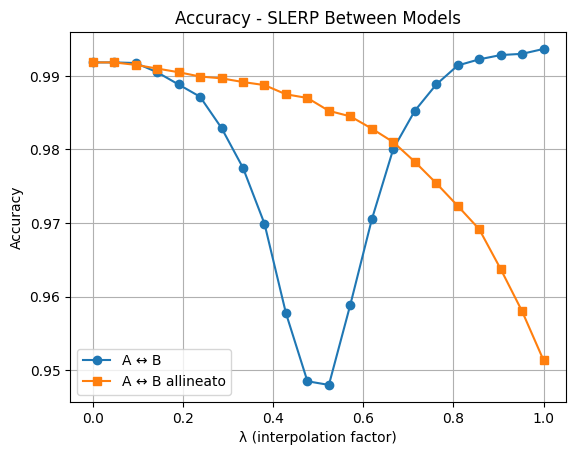

In [148]:
loss_pro_act_slerp,acc_pro_act_slerp=interpolate_slerp_and_loss_barrier(model_a,m_pro_act1, val_naive_slerp,acc_naive_slerp,valid_loader4)
update_loss(loss_pro_act,loss_pro_act_slerp,acc_pro_act,acc_pro_act_slerp,'procrustes_act')

Come si evince dai grafici, i mini algoritmi per la ricerca della rotazione R che minimizza la distanza tra le attivazioni, sono equivalenti. Dunque, per questioni di efficienza, nel corso del notebook si lavorerà esclusivamente con m_pro_act1.

### Procrustes pesi

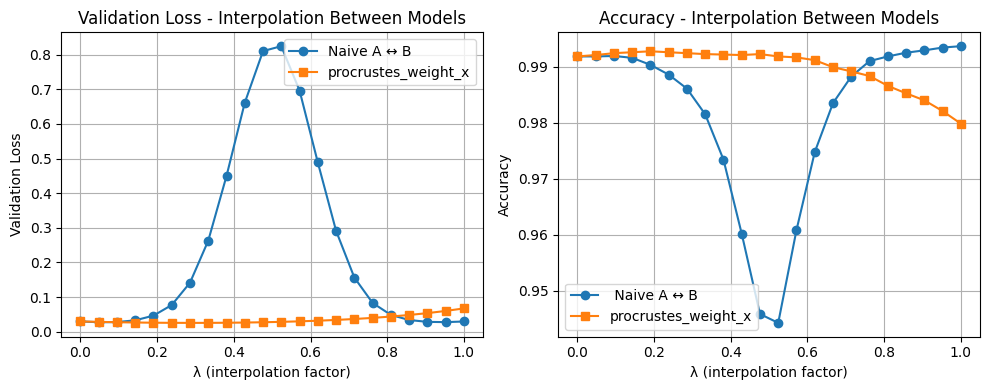

In [149]:
m_pro_weight_x,d_pro_weight_x=apply_pro_weight(model_a,model_b,'not_layer')
val_pro_weight_x,acc_pro_weight_x=comparison_interpolation_method(model_a,m_pro_weight_x,val_naive,acc_naive,valid_loader4,'procrustes_weight_x',1)
loss_pro_weight_x=loss_barrier_efficient(val_pro_weight_x)


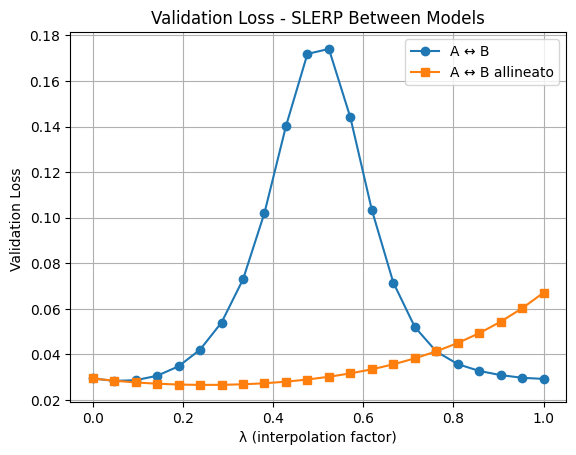

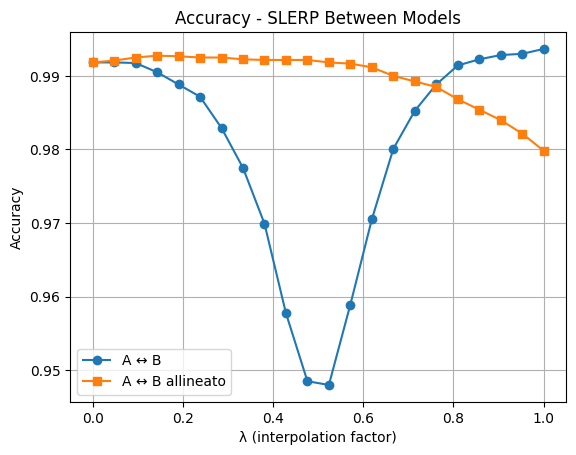

In [150]:
loss_pro_weight_x_slerp,acc_pro_weight_x_slerp=interpolate_slerp_and_loss_barrier(model_a,m_pro_weight_x,val_naive_slerp,acc_naive_slerp,valid_loader4)
update_loss(loss_pro_weight_x,loss_pro_weight_x_slerp,acc_pro_weight_x,acc_pro_weight_x_slerp,'Procrustes_weight_x')

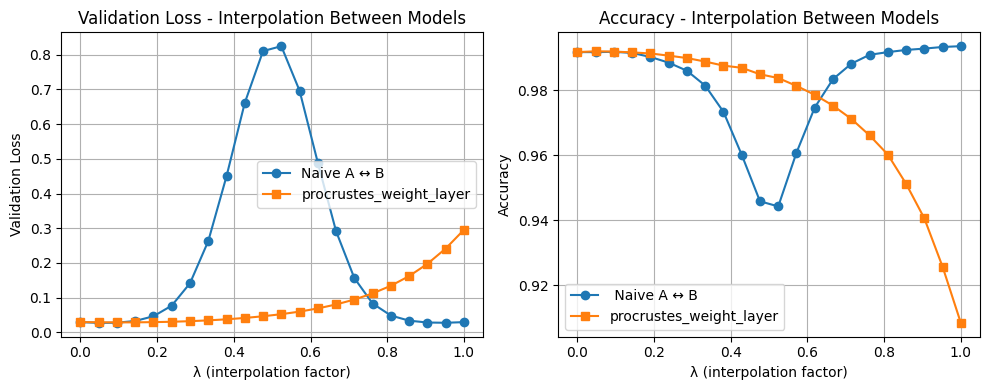

In [151]:
m_pro_weight_l,d_pro_weight_l=apply_pro_weight(model_a,model_b,'layer')
val_pro_weight_l,acc_pro_weight_l=comparison_interpolation_method(model_a,m_pro_weight_l,val_naive,acc_naive,valid_loader4,'procrustes_weight_layer',1)
loss_pro_weight_l=loss_barrier_efficient(val_pro_weight_l)


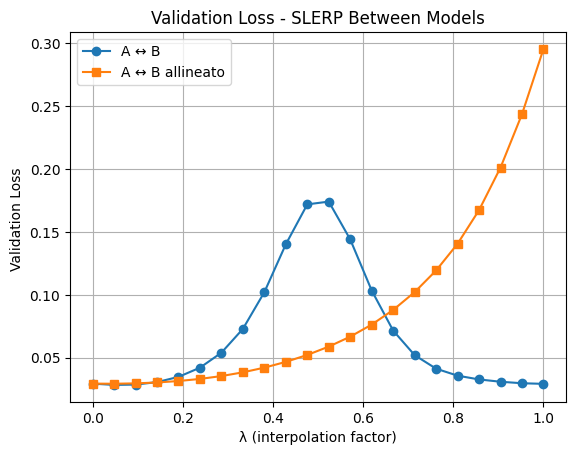

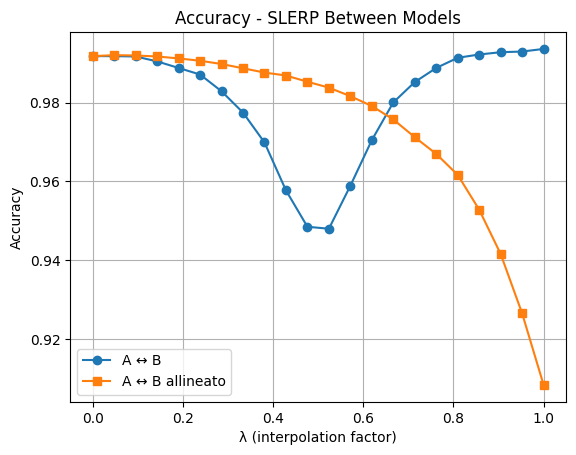

In [152]:
loss_pro_weight_l_slerp,acc_pro_weight_l_slerp=interpolate_slerp_and_loss_barrier(model_a,m_pro_weight_l, val_naive_slerp,acc_naive_slerp,valid_loader4)
update_loss(loss_pro_weight_l,loss_pro_weight_l_slerp,acc_pro_weight_l,acc_pro_weight_l_slerp,'Procrustes_weight_l')

# 📈Confronto

## A livello grafico

### Plot confronto Accuracy Rotations Method SLERP

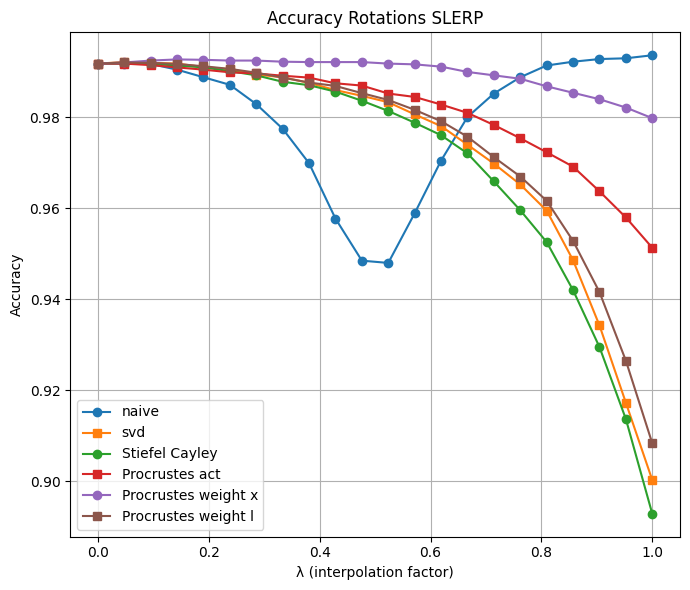

In [153]:
plt.figure(figsize=(7, 6))

plt.plot(lambdas, acc_naive_slerp, marker='o', label="naive")
plt.plot(lambdas, acc_svd_slerp, marker='s', label="svd")
plt.plot(lambdas, acc_stiefel_cayley_slerp, marker='o', label="Stiefel Cayley")
plt.plot(lambdas, acc_pro_act_slerp, marker='s', label="Procrustes act")
plt.plot(lambdas, acc_pro_weight_x_slerp, marker='o', label="Procrustes weight x")
plt.plot(lambdas, acc_pro_weight_l_slerp, marker='s', label="Procrustes weight l")

plt.xlabel("λ (interpolation factor)")
plt.ylabel("Accuracy")
plt.title("Accuracy Rotations SLERP")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


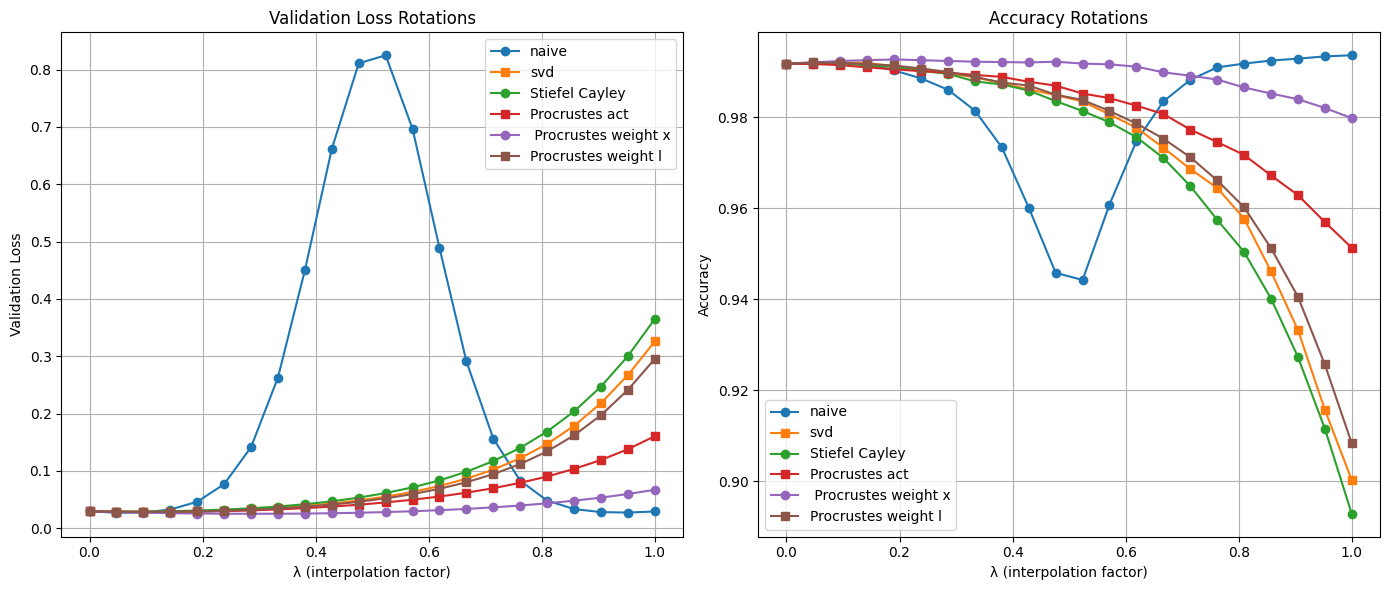

In [154]:
#@title Plot confronto tra Rotation-based methods LERP
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(lambdas, val_naive, marker='o', label="naive")
axs[0].plot(lambdas, val_svd, marker='s', label="svd")
axs[0].plot(lambdas, val_stiefel_cayley, marker='o', label="Stiefel Cayley")
axs[0].plot(lambdas, val_pro_act, marker='s', label="Procrustes act")
axs[0].plot(lambdas, val_pro_weight_x, marker='o', label=" Procrustes weight x")
axs[0].plot(lambdas, val_pro_weight_l, marker='s', label="Procrustes weight l")
axs[0].set_xlabel("λ (interpolation factor)")
axs[0].set_ylabel("Validation Loss")
axs[0].set_title("Validation Loss Rotations")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(lambdas, acc_naive, marker='o', label="naive")
axs[1].plot(lambdas, acc_svd, marker='s', label="svd")
axs[1].plot(lambdas, acc_stiefel_cayley, marker='o', label="Stiefel Cayley")
axs[1].plot(lambdas, acc_pro_act, marker='s', label="Procrustes act")
axs[1].plot(lambdas, acc_pro_weight_x, marker='o', label=" Procrustes weight x")
axs[1].plot(lambdas, acc_pro_weight_l, marker='s', label="Procrustes weight l")
axs[1].set_xlabel("λ (interpolation factor)")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy Rotations")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


*Osservazione:* Si nota come tutti gli algoritmi basati su rotazione siano quasi equivalenti: la validation loss, sebbene bassa, tende ad incrementare verso i modelli interpolati in cui prevale la componente dei pesi del modello $B_{allineato}$,superando in prossimità di lambda=0.7 i valori dell'interpolazione naive. L'implementazione Procruste weight x (che sfrutta la matrice di correlazione lineare) risulta la migliore, con una validation Loss a lambda=1 quasi equivalente a quella del modello di partenza $B$

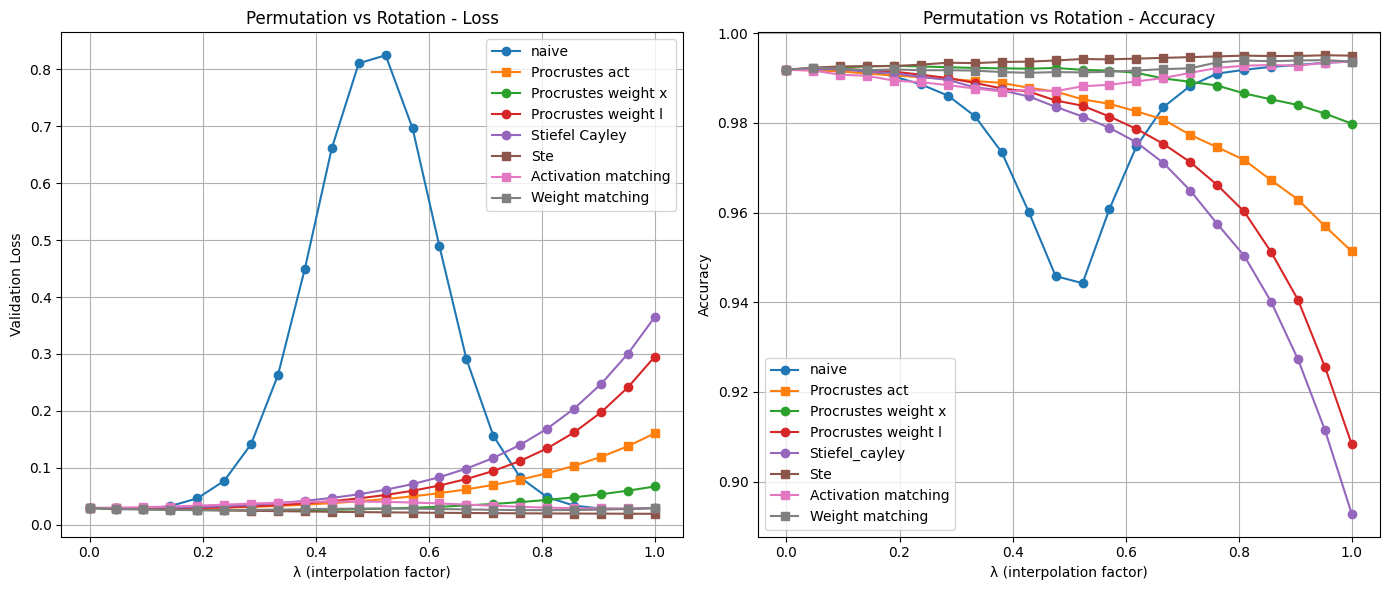

In [155]:
#@title Plot confronto tra Rotation-based methods e Permutation methods

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(lambdas, val_naive, marker='o', label="naive")
axs[0].plot(lambdas, val_pro_act, marker='s', label="Procrustes act")
axs[0].plot(lambdas, val_pro_weight_x, marker='o', label="Procrustes weight x")
axs[0].plot(lambdas, val_pro_weight_l, marker='o', label="Procrustes weight l")
axs[0].plot(lambdas, val_stiefel_cayley, marker='o', label="Stiefel Cayley")
axs[0].plot(lambdas, val_ste, marker='s', label="Ste")
axs[0].plot(lambdas, val_act_match, marker='s', label="Activation matching")
axs[0].plot(lambdas, val_weight_match1, marker='s', label="Weight matching")
axs[0].set_xlabel("λ (interpolation factor)")
axs[0].set_ylabel("Validation Loss")
axs[0].set_title("Permutation vs Rotation - Loss")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(lambdas, acc_naive, marker='o', label="naive")
axs[1].plot(lambdas, acc_pro_act, marker='s', label="Procrustes act")
axs[1].plot(lambdas, acc_pro_weight_x, marker='o', label="Procrustes weight x")
axs[1].plot(lambdas, acc_pro_weight_l, marker='o', label="Procrustes weight l")
axs[1].plot(lambdas, acc_stiefel_cayley, marker='o', label="Stiefel_cayley")
axs[1].plot(lambdas, acc_ste, marker='s', label="Ste")
axs[1].plot(lambdas, acc_act_match, marker='s', label="Activation matching")
axs[1].plot(lambdas, acc_weight_match1, marker='s', label="Weight matching")
axs[1].set_xlabel("λ (interpolation factor)")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Permutation vs Rotation - Accuracy")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

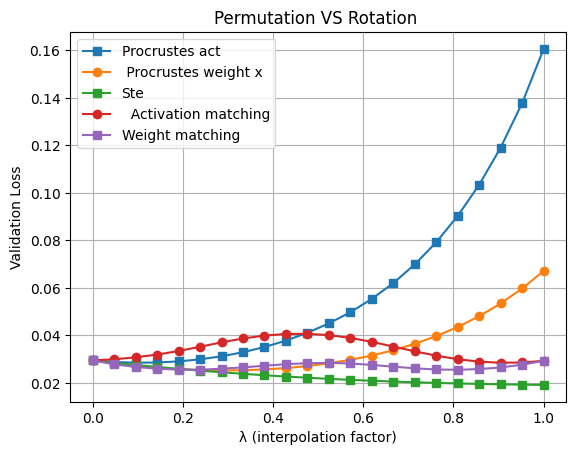

In [156]:
#@title 🔍Zoom

#si analizza più da vicino l'andamento della validation loss dei due metodi di Procruste più efficaci (Procruste activation e Procruste weight x),
#comparandolo con quello dei permutation methods
plt.plot(lambdas, val_pro_act, marker='s', label="Procrustes act")
plt.plot(lambdas, val_pro_weight_x, marker='o', label=" Procrustes weight x")
plt.plot(lambdas, val_ste, marker='s', label="Ste")
plt.plot(lambdas, val_act_match, marker='o', label="  Activation matching")
plt.plot(lambdas, val_weight_match1, marker='s', label="Weight matching")
plt.xlabel("λ (interpolation factor)")
plt.ylabel("Validation Loss")
plt.title("Permutation VS Rotation ")
plt.grid(True)
plt.legend()

plt.show()


*Nota*:Procruste weight x risulta essere il miglior metodo di allineamento con matrici di rotazione. Si ottenengono risultati particolarmente confrontabili e paragonabili a quelli ottenuti con matching activation.

## Livello quantitativo


In [157]:
loss_barriers = pd.DataFrame({'Loss barrier':Loss_barrier,'Loss barrier slerp':Loss_barrier_slerp,'Min accuracy':Min_accuracy,'Min accuracy slerp':Min_accuracy_slerp}, index=Methods_loss_barrier)
loss_barriers


,Loss barrier,Loss barrier slerp,Min accuracy,Min accuracy slerp
naive,0.7955,0.1447,0.944250,0.948000
Activation matching,0.0113,0.0383,0.987000,0.987250
Weight matching,0.0001,0.0101,0.991167,0.991250
Weight matching2,0.0001,0.0072,0.991333,0.991417
Ste,0.0052,0.0052,0.991833,0.991833
SVD matching,0.1483,0.1483,0.900250,0.900250
Stiefel Naive2,0.5940,0.5940,0.704417,0.704417
Stiefel Cayley,0.1678,0.1678,0.892833,0.892833
procrustes_act,0.0656,0.0656,0.951333,0.951333
Procrustes_weight_x,0.0188,0.0188,0.979833,0.979833


Si osserva che la loss barrier calcolata prendendo in esame l'interpolazione tramite slerp assume valori maggiori nel caso di uso di permutazioni, mentre rimane costante se si adoperano rotazioni. Ciò nonostante tramite permutation methods si raggiungono, anche nel caso si SLERP, valori maggiori nel settore accuracy (si evince dal confronto della minima accuracy). I metodi con la loss barrier più bassa risultano Procruste applicato alle attivazioni e alla matrice di correlazione (pro_weight_x). La loss barrier ottenuta negli allineamenti con permutazioni risulta tuttavia sempre più bassa si quelle delle attivazioni

## Livello funzionale

Come evidenziato dai risultati sperimentali, i modelli allineati tramite permutazioni risultano funzionalmente equivalenti al modello originale, a differenza di quanto osservato nel caso delle trasformazioni ortogonali.
Questo fenomeno è analizzato attraverso il calcolo della divergenza di Kullback–Leibler.


## 📚 Kullback–Leibler Divergence (KL Divergence)

La **Kullback–Leibler divergence**  è una misura di quanto una distribuzione di probabilità differisce da un'altra, in particolare quantifica la perdita media di informazione predittiva associata alla sostituzione del modello di riferimento $B$ (denotato come $P$) con il modello allineato $B_{allineato}$ (denotato come $Q$), valutata a parità di input.

$
D_{\mathrm{KL}}(P \parallel Q) = \sum_{i} P(i) \log\left( \frac{P(i)}{Q(i)} \right)
$



| **KL Divergence** | **Interpretazione**                                      |
|-------------------|-----------------------------------------------------------|
| **≈ 0.0001**       | I due modelli sono **funzionalmente identici** |
| **0.01 – 0.05**    | Differenze **minime** nei comportamenti di output         |
| **0.05 – 0.1**     | Differenze **moderate**|
| **> 0.1**          | I modelli mostrano **differenze funzionali più che moderate** |




In [158]:
def functional_error_log_softmax_kl(model_p, model_q, data_loader):
    model_p.eval()
    model_q.eval()
    total_kl = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, _ in data_loader:
            log_probs_p = model_p(inputs)
            log_probs_q = model_q(inputs)

            probs_p = log_probs_p.exp()
            kl_batch = F.kl_div(log_probs_q, probs_p, reduction='batchmean')

            batch_size = inputs.size(0)
            total_kl += kl_batch.item() * batch_size
            total_samples += batch_size

    mean_kl = total_kl / total_samples
    return round(abs(mean_kl),4)


In [159]:
models_kl=[m_act_match,m_weight_match1,m_ste,m_svd,m_stiefel_cayley,m_pro_act1,m_pro_weight_x,m_pro_weight_l]
models_kl_str=['m_act_match','m_weight_match1','m_ste','m_svd','m_stiefel_cayley','m_pro_act1','m_pro_weight_x','m_pro_weight_l']
error_kl=[functional_error_log_softmax_kl(model_p, model_b, valid_loader4) for model_p in models_kl ]
f_e=pd.DataFrame({'Functional error':error_kl},index=models_kl_str)
f_e

,Functional error
m_act_match,0.0000
m_weight_match1,0.0000
m_ste,0.0457
m_svd,1.2062
m_stiefel_cayley,1.4416
m_pro_act1,0.5050
m_pro_weight_x,0.1020
m_pro_weight_l,1.1000


# 🔁 Cycle consistency


Siano $ \mathcal{X} $ e $ \mathcal{Y} $ due insiemi e siano: $
f: \mathcal{X} \to \mathcal{Y} \quad g: \mathcal{Y} \to \mathcal{X}
$  due trasformazioni.

C'è **consistenza ciclica** se: $
g(f(x)) \approx x \quad \forall x \in \mathcal{X}$


Nel contesto delle reti neurali si definiscano:
- $ f $: traformazioni applicate ai pesi di model_b per allinearlo a model_a
- $ g $: trasformazioni inverse per tornare a model_b

Se vi è  consistenza, allora vale:
$
g(f(\text{model}_b)) \approx \text{model}_b
$ oppure, in termini di pesi: $g(f(W_b)) \approx W_b
$.



Negli allineamenti le trasformazioni $T$ (siano esse permutazioni o rotazioni) vengono applicate ai pesi di un modello $M$, dunque ci si chiede se applicando le loro inverse ai pesi del modello trasformato si recupera il modello originale, ci si interroga dunque se vi è, in tal senso, consistenza ciclica.

In [160]:
#Costruzione del modello originale partendo dal modello allineato, applicando le inverse delle matrici di trasformazioni adoperate per trasformare B in B allineato

def rebuild(new_model,model_b,R_dict,layer_names=['fc1','fc2','fc3','fc4']):  #R_dict contiene le matrici adoperate per allineare B ad A
    W_ricostruito=copy.deepcopy(new_model)
    for i, layer in enumerate(layer_names):
        W_a = getattr(new_model, layer).weight.data
        W_b = getattr(model_b, layer).weight.data
        b_a=getattr(new_model, layer).bias.data
        b_b=getattr(model_b, layer).bias.data
        if i == 0:
            R_l = R_dict[layer]
            W_b_reconstructed = R_l.T @ W_a
            b_b_reconstructed=R_l.T @ b_a
        elif i==3:
            W_b_reconstructed =  W_a @ R_prev
            b_b_reconstructed=b_a
        else:
            R_l = R_dict[layer]
            W_b_reconstructed = R_l.T @ W_a @ R_prev
            b_b_reconstructed=R_l.T @ b_a
        layer_perm = getattr(W_ricostruito, layer)
        with torch.no_grad():
            layer_perm.weight.data.copy_(W_b_reconstructed)
            layer_perm.bias.data.copy_(b_b_reconstructed)
        R_prev = R_l
    return W_ricostruito


def cycle_model(model_a,model_b,b_rec,valid_dl):
   val_losses_ab ,acc_ab= [],[]
   val_losses_abr ,acc_abr= [],[]
   for lam in lambdas:
        interpolated = interpolate_models(model_a, model_b, lam)
        loss,acc = evaluate_loss(interpolated, valid_dl, loss_fn)
        acc_ab.append(acc)
        val_losses_ab.append(loss)

        interpolatedr = interpolate_models(model_a, b_rec, lam)
        lossr,accr = evaluate_loss(interpolated, valid_dl, loss_fn)
        acc_abr.append(accr)
        val_losses_abr.append(lossr)

   plt.plot(lambdas, val_losses_ab, label='naive')
   plt.plot(lambdas, val_losses_abr, marker='o', label='ricostruito')
   plt.xlabel('λ (interpolation factor)')
   plt.ylabel('Validation Loss')
   plt.title('MNIST MLP')
   plt.grid(True)
   plt.legend()
   plt.show()

name_MAE,MAE,Err_l2=[],[],[]
def Cycle_Reconstruction_Error(model1, model2,stringa):
    MAE_,l2 = [],[]
    name_MAE.append(stringa)

    params1 = list(model1.parameters())
    params2 = list(model2.parameters())

    for (p1, p2) in zip(params1, params2):
        if len(p1.shape) == 2:
            l1_error = torch.norm(p1.data - p2.data,p=1)
            l2_error = torch.norm(p1.data - p2.data,p=2)
            MAE_.append(round(l1_error.item()/p1.numel(),3))
            l2.append(round(l2_error.item(),3))

    MAE.append(MAE_)
    Err_l2.append(l2)

    return l2


Si propongono due esempi pratici di tale consistenza ciclica (uno nel caso in cui le trasformazioni sono permutazioni, l'altro in cui sono matrici di rotazione)

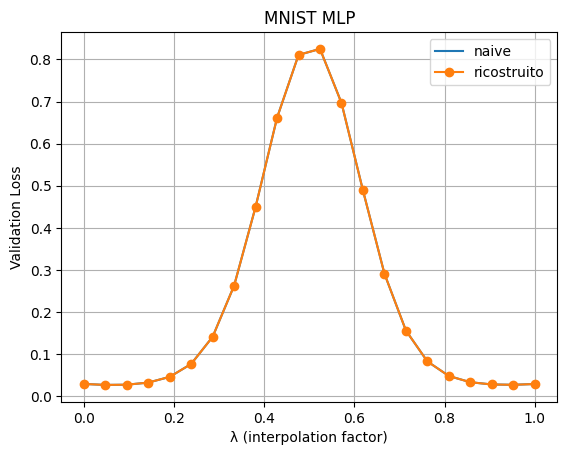

[0.0, 0.0, 0.0, 0.0]


In [161]:
b_rec_p=rebuild(m_act_match,model_b,d_act_match)
cycle_model(model_a,model_b,b_rec_p,valid_loader4)

#si osserva che l'interpolazione tra i modelli A e B e l'interpolazione tra i modelli A e B ricostruito coincidono-->B ricostruito coincide con B

print(Cycle_Reconstruction_Error(b_rec_p,model_b,'confronto'))

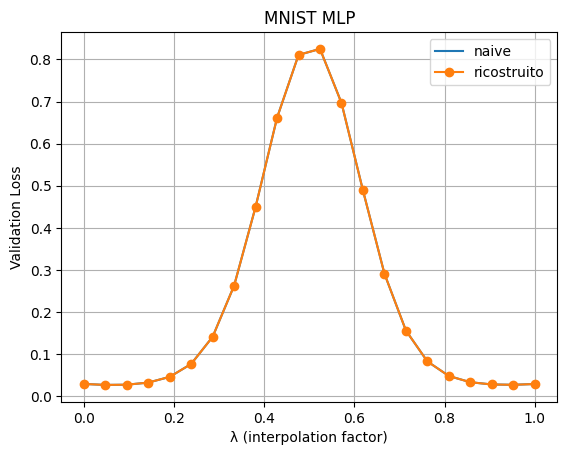

[0.0, 0.001, 0.0, 0.0]


In [162]:
b_rec_r=rebuild(m_stiefel_cayley,model_b,d_stiefel_cayley)
cycle_model(model_a,model_b,b_rec_r,valid_loader4)
print(Cycle_Reconstruction_Error(b_rec_r,model_b,'confronto'))

## Misurare la cycle consistency



Misurare la **cycle consistency** delle trasformazioni applicate consiste nel verificare quanto la loro 'composizione' sia vicina all'identità. Una metrica utile a tale scopo è **la deviazione angolare**, definita come:

$$
\theta = \cos^{-1} \left( \frac{\operatorname{Tr}(Q_{BA} Q_{AB})}{d} \right)
$$

con $Q_{AB}$ e $Q_{BA}$ matrici adoperate nelle trasformazioni e $d$ la loro dimensione. Un angolo più piccolo indica una migliore consistenza ciclica:un angolo pari a zero corrisponde a un'inversione perfetta.





In [163]:
def angular_deviation(Q_AB, Q_BA):
    d = Q_AB.shape[0]
    product = torch.matmul(Q_BA, Q_AB)
    trace = torch.trace(product).item()
    cos_theta = trace / d
    cos_theta = max(min(cos_theta, 1.0), -1.0)
    theta = math.acos(cos_theta)
    return theta    #in radianti

m_names,ang_deviation,ordine_fro,norma_fro=[],[],[],[]

def cycle_consistency(d_a:dict, d_b:dict,model_name:str, layer_names=['fc1', 'fc2', 'fc3']):
    norma_frobenius=[]
    ang_dev=[]
    for layer in layer_names:
        M_a = d_a[layer]
        M_b = d_b[layer]

        identity = torch.eye(M_a.shape[0])

        ang_dev.append(round(angular_deviation(M_a,M_b),3))

        norma_f =torch.norm(M_a @ M_b - identity, 'fro').item()
        norma_frobenius.append(round(norma_f,3))

    v = norma_f/ len(layer_names)
    if v == 0:
        magnitude = "0"
    else:
        magnitude = f"1e{int(math.floor(math.log10(v)))}"

    m_names.append(model_name)
    ordine_fro.append(magnitude)
    norma_fro.append(norma_frobenius)
    ang_deviation.append(ang_dev)

    return magnitude



Siano $A$ e $B$ due modelli indipendenti, e sia $B_{\text{tras}}$ il modello ottenuto trasformando i pesi di $B$ per allinearli a $A$.

Si definiscono:

- $B_{\text{rec}_B}$: modello ottenuto riallineando $B_{\text{tras}}$ per riportarlo su $B$
- $B_{\text{rec}_A}$: modello ottenuto riallineando $A$ per riportarlo su $B$.
Si pone la tuttavia seguente questione:qualora non sia soddisfatta la cycle consistency, il nuovo modello $B_{\text{rec}}$ è comunque simile a $B$? Per verificarlo si studia la similarità dei pesi,facendo uso della MAE.



**MAE (Mean Absolute Error):**

Siano $A$ e $B$ due tensori con $N$ elementi corrispondenti, la MAE è definita come:

$$
\mathrm{MAE}(A, B) = \frac{1}{N} \sum_{i=1}^N |A_i - B_i|
$$

| MAE per elemento | L1 totale attesa | Interpretazione (basata su matrici 512*512)                   |
| ---------------- | ---------------- | ---------------------------------- |
| 0.001            | $\sim 260$       | **Molto simili** (quasi identiche) |
| 0.01             | $\sim 2{,}600$   | Simili                             |
| 0.1              | $\sim 26{,}000$  | Abbastanza diverse                 |
| >0.3             | $> 78{,}000$     | Diverse                            |

Di seguito si riportano delle metriche di distanza tra i pesi originari di $B$ e quelli dei modelli ricostruiti

In [164]:
#@title Misure di distanza tra i pesi originari di B e quelli di B_ricostruito partendo da B_allineato
name_MAE,MAE,Err_l2=[],[],[]
m_names,ang_deviation,ordine_fro,norma_fro=[],[],[],[]

m_act_match_inv,d_act_match_inv=activation_matching(model_b, m_act_match, layer_names, valid_loader3)
_=cycle_consistency(d_act_match,d_act_match_inv,'m_act_match_inv')
_=Cycle_Reconstruction_Error(m_act_match_inv,model_b,'m_act_match_inv')

m_weight_match1_inv,d_weight_match1_inv=apply_match_weights(model_b,m_weight_match1,'not_descent')
_=cycle_consistency(d_weight_match1,d_weight_match1_inv,'m_weight_match1_inv')
_=Cycle_Reconstruction_Error(m_weight_match1_inv,model_b,'m_weight_match1_inv')

m_svd_inv,d_svd_inv=svd_weight_matching(model_b, m_svd, layer_names)
_=cycle_consistency(d_svd,d_svd_inv,'m_svd_inv')
_=Cycle_Reconstruction_Error(m_svd_inv,model_b,'m_svd_inv')

m_pro_act1_inv,d_pro_act1_inv=rotate_activations_procrustes(model_b, m_pro_act1, layer_names, valid_loader3,1)
_=cycle_consistency(d_pro_act1,d_pro_act1_inv,'m_pro_act1_inv')
_=Cycle_Reconstruction_Error(m_pro_act1_inv,model_b,'m_pro_act1_inv')

m_pro_weight_l_inv,d_pro_weight_l_inv=apply_pro_weight(model_b,m_pro_weight_l,'layer')
_=cycle_consistency(d_pro_weight_l,d_pro_weight_l_inv,'m_pro_weight_l_inv')
_=Cycle_Reconstruction_Error(m_pro_weight_l_inv,model_b,'m_pro_weight_l_inv')

m_pro_weight_x_inv,d_pro_weight_x_inv=apply_pro_weight(model_b,m_pro_weight_x,'not_layer')
_=cycle_consistency(d_pro_weight_x,d_pro_weight_x_inv,'m_pro_weight_x_inv')
_=Cycle_Reconstruction_Error(m_pro_weight_x_inv,model_b,'m_pro_weight_x_inv')

m_stiefel_cayley_inv,d_stiefel_cayley_inv=stiefel_cayley(model_b, m_stiefel_cayley, layer_names)
_=cycle_consistency(d_stiefel_cayley,d_stiefel_cayley_inv,'m_stiefel_cayley_inv')
_=Cycle_Reconstruction_Error(m_stiefel_cayley_inv,model_b,'m_stiefel_cayley_inv')

MAE=pd.DataFrame({'MAE':MAE,'ErroreL2 B_rec_b':Err_l2,'Ordine errore cycle consistency':ordine_fro},index=name_MAE)
FRO_b_trs=pd.DataFrame({'ErroreFrobenius B_rec_b':norma_fro,'Angol deviation B_rec_b':ang_deviation},index=name_MAE)
MAE

,MAE,ErroreL2 B_rec_b,Ordine errore cycle consistency
m_act_match_inv,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",0
m_weight_match1_inv,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",0
m_svd_inv,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.018, 0.002]",1e-2
m_pro_act1_inv,"[0.002, 0.028, 0.03, 0.023]","[2.515, 17.698, 19.165, 2.133]",1e1
m_pro_weight_l_inv,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.017, 0.002]",1e-2
m_pro_weight_x_inv,"[0.0, 0.0, 0.0, 0.0]","[0.02, 0.041, 0.033, 0.005]",1e-2
m_stiefel_cayley_inv,"[0.007, 0.014, 0.015, 0.018]","[5.975, 8.972, 9.718, 1.664]",1e0


In [165]:
FRO_b_trs

,ErroreFrobenius B_rec_b,Angol deviation B_rec_b
m_act_match_inv,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
m_weight_match1_inv,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
m_svd_inv,"[0.0, 0.044, 0.033]","[0.0, 0.002, 0.001]"
m_pro_act1_inv,"[6.086, 29.344, 30.806]","[0.27, 1.411, 1.498]"
m_pro_weight_l_inv,"[0.0, 0.04, 0.031]","[0.0, 0.002, 0.001]"
m_pro_weight_x_inv,"[0.043, 0.197, 0.19]","[0.002, 0.009, 0.008]"
m_stiefel_cayley_inv,"[15.881, 20.934, 23.677]","[0.717, 0.962, 1.101]"


In [166]:
#@title Ordine errore ciclico tra il modello B e il modello B_ricostruito ottenuto mediante rotation methods da A
m_names,ang_deviation,ordine_fro,norma_fro=[],[],[],[]
m_act_match_inv,d_act_match_inv=activation_matching(model_b, model_a, layer_names, valid_loader3)
_=cycle_consistency(d_act_match,d_act_match_inv,'m_act_match_inv')

m_weight_match1_inv,d_weight_match1_inv=apply_match_weights(model_b,model_a,'not_descent')
_=cycle_consistency(d_weight_match1,d_weight_match1_inv,'m_weight_match1_inv')

m_svd_inv,d_svd_inv=svd_weight_matching(model_b, model_a, layer_names)
_=cycle_consistency(d_svd,d_svd_inv,'m_svd_inv')

m_pro_act1_inv,d_pro_act1_inv=rotate_activations_procrustes(model_b, model_a, layer_names, valid_loader3,1)
_=cycle_consistency(d_pro_act1,d_pro_act1_inv,'m_pro_act1_inv')

m_pro_weight_l_inv,d_pro_weight_l_inv=apply_pro_weight(model_b,model_a,'layer')
_=cycle_consistency(d_pro_weight_l,d_pro_weight_l_inv,'m_pro_weight_l_inv')

m_pro_weight_x_inv,d_pro_weight_x_inv=apply_pro_weight(model_b,model_a,'not_layer')
_=cycle_consistency(d_pro_weight_x,d_pro_weight_x_inv,'m_pro_weight_x_inv')


m_stiefel_cayley_inv,d_stiefel_cayley_inv=stiefel_cayley(model_b, model_a, layer_names)
_=cycle_consistency(d_stiefel_cayley,d_stiefel_cayley_inv,'m_stiefel_cayley_inv')
CYCLE=pd.DataFrame({'Ordine errore cycle consistency B_rec_a':ordine_fro},index=m_names)
FRO_a=pd.DataFrame({'ErroreFrobenius B_rec_a':norma_fro,'Angol_deviation B_rec_a':ang_deviation},index=m_names)
CYCLE

,Ordine errore cycle consistency B_rec_a
m_act_match_inv,0
m_weight_match1_inv,0
m_svd_inv,1e-4
m_pro_act1_inv,1e0
m_pro_weight_l_inv,1e-4
m_pro_weight_x_inv,1e-4
m_stiefel_cayley_inv,1e0


In [167]:
FRO_a

,ErroreFrobenius B_rec_a,Angol_deviation B_rec_a
m_act_match_inv,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
m_weight_match1_inv,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
m_svd_inv,"[0.0, 0.002, 0.003]","[0.0, 0.0, 0.0]"
m_pro_act1_inv,"[7.6, 8.266, 14.476]","[0.337, 0.367, 0.651]"
m_pro_weight_l_inv,"[0.0, 0.002, 0.002]","[0.0, 0.0, 0.0]"
m_pro_weight_x_inv,"[0.001, 0.001, 0.002]","[0.0, 0.0, 0.0]"
m_stiefel_cayley_inv,"[18.882, 24.415, 27.143]","[0.861, 1.14, 1.286]"


E' opportuno ricordare che gli 0.0 derivano da arrotondamenti, si tratta comunque di errori talmente piccoli da poter essere trascurati. Inoltre, per quanto concerne gli errori calcolari in norma di Frobenius, è opportuno ricordare le grandi dimensioni delle matrici.

# Errori tra le reti

## Non commutatività ReLu


La commutatività della ReLu rispetto alle permutazioni spiega il motivo per cui le permutazioni possano rendere due modelli equivalenti funzionalmente, se opportunamente compensate. Tale proprietà non vale se si adoperano matrici di rotazione. A tal proposito si calcola l'errore di non linearità, definito come:
$
E_{\text{nonlinear}} = \| \text{ReLU}(Qx) - Q \cdot \text{ReLU}(x) \|^2
$



In [168]:
def get_multiple_fc_activations2(model, layer_names, inputs):
    activations = {}
    x = inputs.view(inputs.size(0), -1)
    for layer_name in layer_names:
        layer = getattr(model, layer_name)
        h = layer(x)
        activations[layer_name] = h.detach()  # pre-ReLU
        x = F.relu(h)

    return activations


In [169]:
non_commutativity_error,model_name=[],[]
def n_commutativity_error(model_b, b_allineato, valid_dl, stringa, trasformazioni, layer_names=['fc1', 'fc2', 'fc3']):
    rot = [trasformazione for trasformazione in trasformazioni.values()]
    errori_cumulativi = [0.0 for _ in layer_names]
    num_batches = 0

    for inputs, _ in valid_dl:
        x = inputs.view(inputs.size(0), -1).T
        dizB = get_multiple_fc_activations2(b_allineato, layer_names, inputs)
        x_curr = x.clone()

        for i, layer in enumerate(layer_names):
            Zb = dizB[layer].T
            Zb=F.relu(Zb)
            Wl = getattr(model_b, layer).weight.data.clone()
            bl = getattr(model_b, layer).bias.data.clone()

            if i == 0:
                h = Wl @ x_curr + bl.unsqueeze(1)
            else:
                h = Wl @ rot[i - 1].T @ x_curr + bl.unsqueeze(1)

            a = F.relu(h)

            x_curr = rot[i] @ a

            error = torch.norm(Zb - x_curr, p=2)
            errori_cumulativi[i] += error.item()

        num_batches += 1
    errori_medi = [format(e / num_batches,".1e") for e in errori_cumulativi]

    model_name.append(stringa)
    non_commutativity_error.append(errori_medi)
    return errori_medi


In [170]:
#@title Tabella errore non commutatività
_=n_commutativity_error(model_b, m_act_match, valid_loader4, 'm_act_match', d_act_match, layer_names=['fc1', 'fc2', 'fc3'])
_=n_commutativity_error(model_b, m_weight_match1, valid_loader4, 'm_weight_match1', d_weight_match1, layer_names=['fc1', 'fc2', 'fc3'])
_=n_commutativity_error(model_b, m_ste, valid_loader4, 'm_ste', d_ste, layer_names=['fc1', 'fc2', 'fc3'])
_=n_commutativity_error(model_b, m_svd, valid_loader4, 'm_svd', d_svd, layer_names=['fc1', 'fc2', 'fc3'])
_=n_commutativity_error(model_b, m_pro_act1, valid_loader4, 'm_pro_act1', d_pro_act1, layer_names=['fc1', 'fc2', 'fc3'])
_=n_commutativity_error(model_b, m_pro_weight_x, valid_loader4, 'm_pro_weight_x', d_pro_weight_x, layer_names=['fc1', 'fc2', 'fc3'])
_=n_commutativity_error(model_b, m_pro_weight_l, valid_loader4, 'm_pro_weight_l', d_pro_weight_l, layer_names=['fc1', 'fc2', 'fc3'])
_=n_commutativity_error(model_b, m_stiefel_cayley, valid_loader4, 'm_stiefel_cayley', d_stiefel_cayley, layer_names=['fc1', 'fc2', 'fc3'])
pd.DataFrame({'Non commutativity error':non_commutativity_error},index=model_name)

,Non commutativity error
m_act_match,"[6.7e-06, 1.4e-05, 3.8e-05]"
m_weight_match1,"[6.8e-06, 1.4e-05, 3.9e-05]"
m_ste,"[7.8e+01, 1.0e+02, 2.6e+02]"
m_svd,"[7.5e+01, 1.3e+02, 3.2e+02]"
m_pro_act1,"[7.7e+01, 1.2e+02, 3.0e+02]"
m_pro_weight_x,"[6.8e+01, 8.2e+01, 2.6e+02]"
m_pro_weight_l,"[7.6e+01, 1.3e+02, 3.2e+02]"
m_stiefel_cayley,"[7.7e+01, 1.3e+02, 3.3e+02]"


Si osserva come i valori di tale errore siano, come ci si aspettava, trascurabili nel caso di permutazioni, mentre diventano più significati in presenza di matrici di rotazione

## Residual Misalignment error

### 📊 Linear CKA (Centered Kernel Alignment)
La Centered Kernel Alignment (CKA) è una misura efficace per valutare la similarità tra le rappresentazioni apprese da due reti neurali, anche prima di applicare tecniche di allineamento esplicito. Grazie alla sua invarianza rispetto a trasformazioni ortogonali e scalari, la CKA è in grado di rilevare similarità strutturali tra rappresentazioni che, pur geometricamente trasformate, condividono contenuti informativi simili.

Dunque si ritiene opportuno adoperare tale strumento, in particolare la **Linear CKA**, per captare la similirità tra rappresentazioni,spesso celata dietro delle trasformazioni.Si vuole dunque capire se ruotando le rappresentazioni interne si possa osservare un allineamento, già "predetto" dalla CKA

### 🧠 Formula (Linear CKA)

$$
\text{CKA}_{\text{lin}}(X, Y) = \frac{\| Y^\top X \|_F^2}{\| X^\top X \|_F \cdot \| Y^\top Y \|_F}
$$


Dove:
- $X, Y \in \mathbb{R}^{n \times d} $ sono le rappresentazioni
- $\| \cdot \|_F $ è la norma di Frobenius

 .

In [171]:
def _debiased_dot_product_similarity_helper(
    xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y,
    n):
  return (
      xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))

def feature_space_linear_cka(features_x, features_y, debiased=False):
  features_x = features_x - np.mean(features_x, 0, keepdims=True)
  features_y = features_y - np.mean(features_y, 0, keepdims=True)

  dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
  normalization_x = np.linalg.norm(features_x.T.dot(features_x))
  normalization_y = np.linalg.norm(features_y.T.dot(features_y))

  if debiased:
    n = features_x.shape[0]
    sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
    sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
    squared_norm_x = np.sum(sum_squared_rows_x)
    squared_norm_y = np.sum(sum_squared_rows_y)

    dot_product_similarity = _debiased_dot_product_similarity_helper(
        dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
        squared_norm_x, squared_norm_y, n)
    normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
        squared_norm_x, squared_norm_x, n))
    normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
        squared_norm_y, squared_norm_y, n))

  return dot_product_similarity / (normalization_x * normalization_y)

def layer_similarity(model_a, model_b, valid_dl, layer_names):
    dizA = get_multiple_fc_activations(model_a, layer_names, valid_dl)
    dizB = get_multiple_fc_activations(model_b, layer_names, valid_dl)
    similarity = {}

    for layer in layer_names:
        Z_A = dizA[layer].cpu().numpy()
        Z_B = dizB[layer].cpu().numpy()
        similarity[layer] = feature_space_linear_cka(Z_A.T, Z_B.T)

    return similarity



In [172]:
layer_similarity(model_a, model_b, valid_loader4, layer_names)

{'fc1': np.float32(0.98658663),
 'fc2': np.float32(0.93339443),
 'fc3': np.float32(0.9267003)}

### 🔍PCA
Si conduce una breve analisi qualitativa finalizzata a valutare la similarità strutturale delle rappresentazioni apprese, sia prima che dopo un opportuno processo di allineamento. Tale valutazione viene effettuata mediante l’applicazione della PCA sulle prime due componenti principali, al fine di generare visualizzazioni grafiche che ne facilitano un’interpretazione immediata e intuitiva.

In [173]:
from sklearn.decomposition import PCA

def visual_similarity(model_a, model_b, valid_dl, layer_names):
    dizA = get_multiple_fc_activations(model_a, layer_names, valid_dl)
    dizB = get_multiple_fc_activations(model_b, layer_names, valid_dl)
    for layer in layer_names:
        Z_A = dizA[layer].cpu().numpy()
        Z_B = dizB[layer].cpu().numpy()
        pca_A = PCA(n_components=2)
        pca_B = PCA(n_components=2)

        Z_A_pca = pca_A.fit_transform(Z_A)
        Z_B_pca = pca_B.fit_transform(Z_B)
        colors = Z_A_pca[:, 0]
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        fig.suptitle(f"Layer: {layer} ", fontsize=14)

        axes[0].scatter(Z_A_pca[:, 0], Z_A_pca[:, 1], c=colors, cmap='viridis', s=10)
        axes[0].set_title("PCA attivazioni Modello A")
        axes[0].set_xlabel("PC1")
        axes[0].set_ylabel("PC2")

        axes[1].scatter(Z_B_pca[:, 0], Z_B_pca[:, 1], c=colors, cmap='viridis', s=10)
        axes[1].set_title("PCA attivazioni Modello B")
        axes[1].set_xlabel("PC1")
        axes[1].set_ylabel("PC2")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()



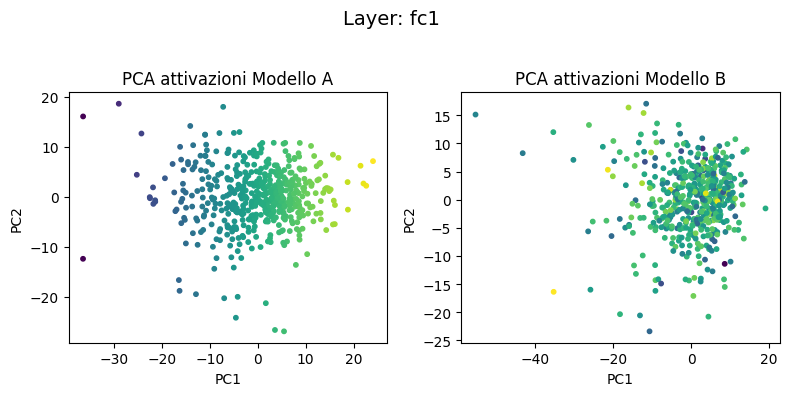

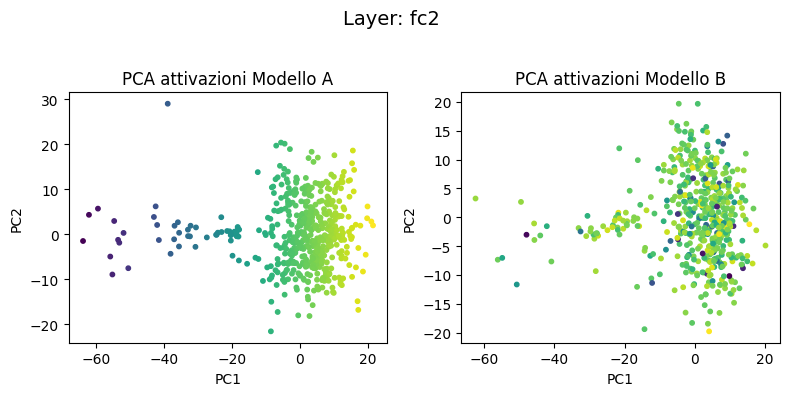

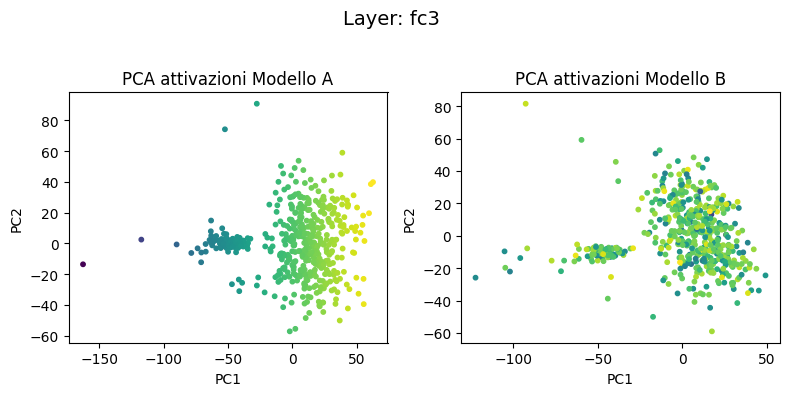

In [174]:
visual_similarity(model_a, model_b, valid_loader4, layer_names)    #attivazioni prima dell'allineamento

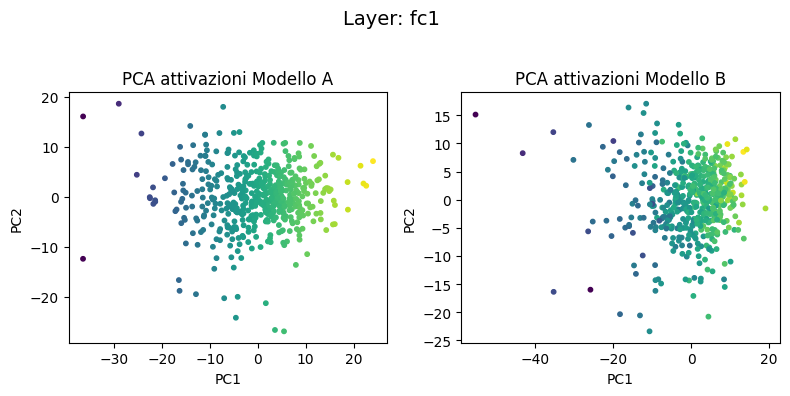

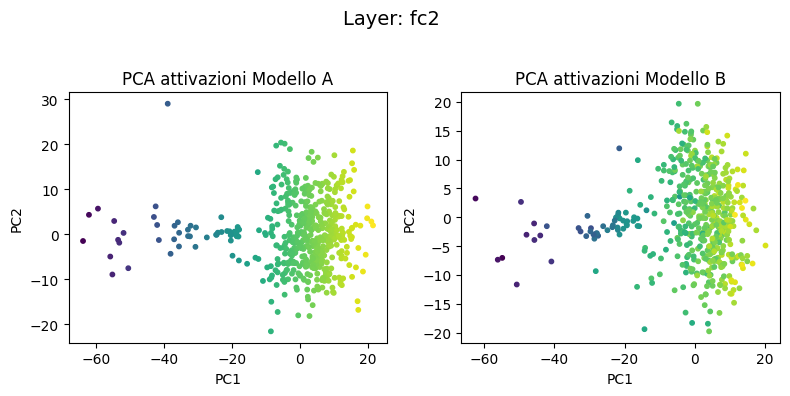

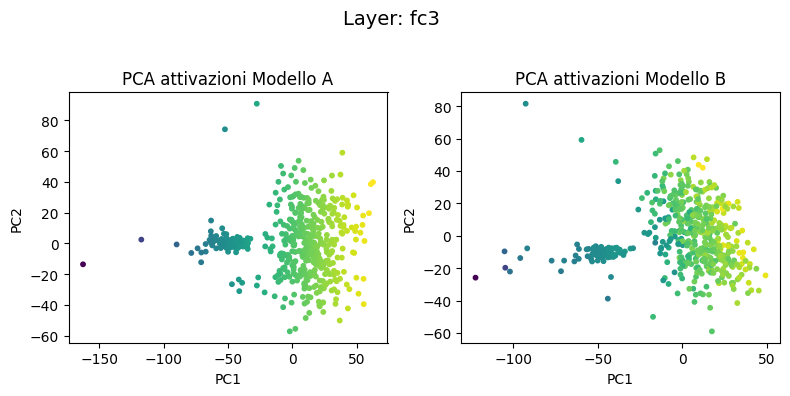

In [175]:
visual_similarity(model_a,m_act_match, valid_loader4, layer_names)  #attivazioni dopo allineamento con activation matching (permutazioni)


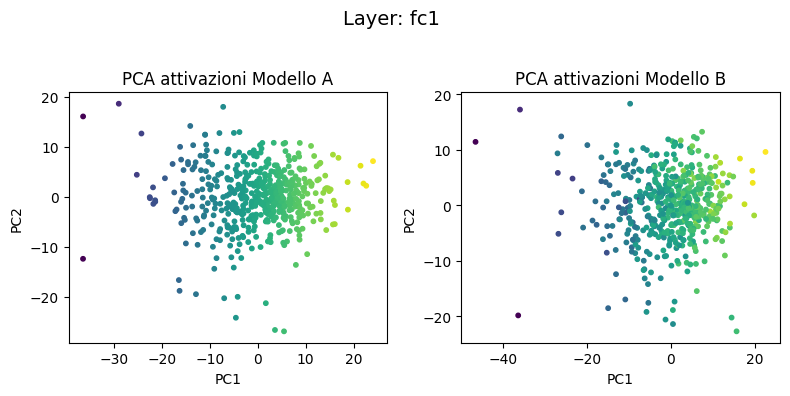

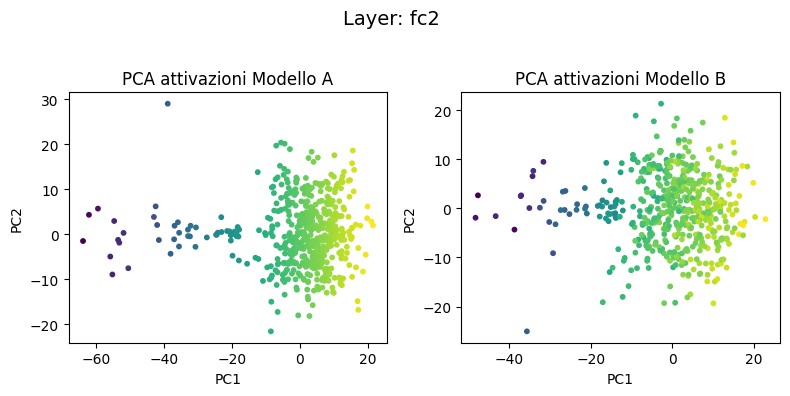

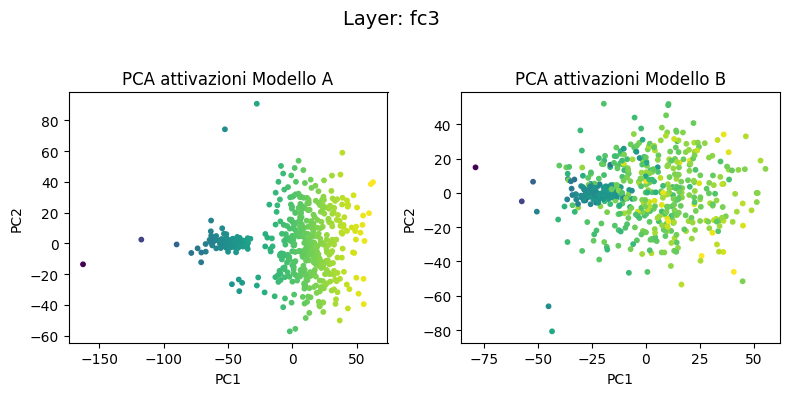

In [176]:
visual_similarity(model_a,m_svd, valid_loader4, layer_names)        #attivazioni dopo allineamento con activation matching (rotazione sui pesi)

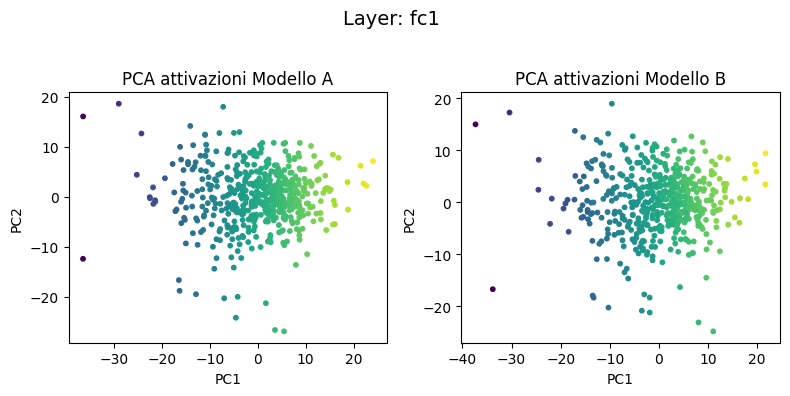

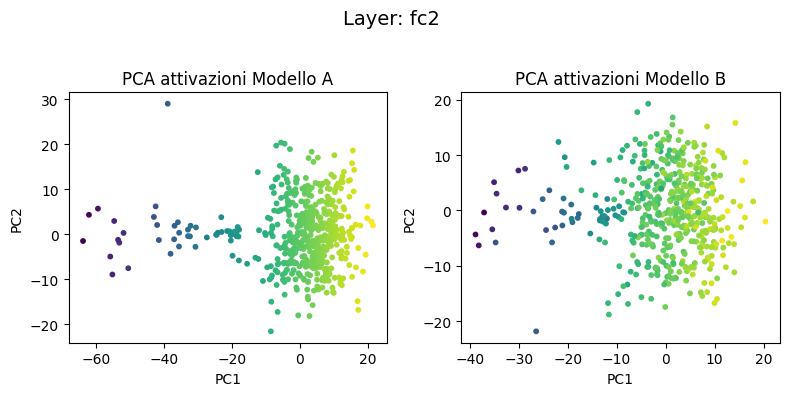

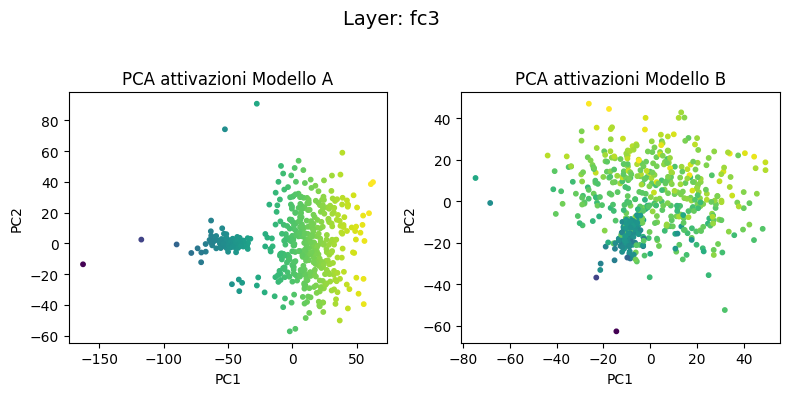

In [177]:
visual_similarity(model_a,m_pro_act1, valid_loader4, layer_names)        #attivazioni dopo allineamento su attivazioni con procruste

Si osserva come si raggiunge un buon livello di allineamento sia con algoritmi che mirano a minimizzare la distanza tra le attivazioni, sia con gli algoritmi che mirano a minimizzare la distanza tra le matrici dei pesi.

Risulta evidente che l'allineamento è migliore nei primi layer, e tende a peggiorare aumentandome la profondità. Questo verrà confermato poi anche a livello quantitativo.

### 📏 Misalignment Error tra Modelli Allineati

Dati i modelli $M_1$ e $M_2$  **allineati** tramite trasformazione $T$, si definisce l'**errore di misallineamento** a livello di layer $l$ come:

$$
E_{\text{align}}^{(l)} = \mathbb{E}_{x} \left[ \left\| T\big(h^{(1)}_l(x)\big) - h^{(2)}_l(x) \right\|_2^2 \right]
$$

dove:
- $h^{(1)}_l(x)$ sono le attivazioni del layer $l$ del modello $M_1$ con input $x$,
- $h^{(2)}_l(x)$ sono le attivazioni corrispondenti del modello $M_2$,
- $T$ è la trasformazione di allineamento applicata alle attivazioni di $M_1$,
- $\|\cdot\|_2$ è la norma Euclidea (o norma di Frobenius se si considera il batch).

In [178]:
pre,post,ampl,names=[],[],[],[]
def residual_error(model_a, model_b, valid_dl,stringa, layer_names=['fc1', 'fc2', 'fc3'], epsilon=1e-8):
    dizA = get_multiple_fc_activations(model_a, layer_names, valid_dl)
    dizB = get_multiple_fc_activations(model_b, layer_names, valid_dl)

    error_pre, error_post, amplification = [],[],[]

    for layer in layer_names:
        Z_A = dizA[layer]
        Z_B = dizB[layer]

        err_pre = torch.mean((Z_A - Z_B) ** 2)
        error_pre.append( round(err_pre.item(),3))

        H_A = F.relu(Z_A)
        H_B = F.relu(Z_B)

        err_post = torch.mean((H_A - H_B) ** 2)
        error_post.append(round(err_post.item(),3))

        amplification.append(round((err_post / (err_pre + epsilon)).item(),3))

    names.append(stringa)
    pre.append(error_pre)
    post.append(error_post)
    ampl.append(amplification)

    return error_pre


L'**Amplificazione** indica quanto la differenza tra le attivazioni di due modelli venga aumentata o ridotta dopo l’applicazione della funzione di attivazione (in questo caso, la ReLU). Si calcola come il rapporto tra l’errore post-attivazione e l’errore pre-attivazione:

$$
\text{Amplificazione} = \frac{\text{Errore Post-attivazione}}{\text{Errore Pre-attivazione} + \varepsilon}
$$

Un valore di amplificazione maggiore di 1 indica che la funzione di attivazione ha amplificato le differenze tra i modelli, mentre un valore minore di 1 indica una riduzione di tali differenze.


In [179]:
#@title Tabella errori pre e post Relu
pre,post,ampl,names=[],[],[],[]

res_m_weight_match1=residual_error(m_weight_match1, model_a, valid_loader4, 'm_weight_match1')
res_m_ste=residual_error(m_ste, model_a, valid_loader4, 'm_ste')
res_m_svd_match1=residual_error(m_svd, model_a, valid_loader4, 'm_svd')
res_m_pro_act1=residual_error(m_pro_act1, model_a, valid_loader4, 'm_pro_act1')
res_m_pro_weight_x=residual_error(m_pro_weight_x, model_a, valid_loader4, 'm_pro_weight_x')
res_m_pro_weight_l=residual_error(m_pro_weight_l, model_a, valid_loader4, 'm_pro_weight_l')
res_m_stiefel_cayley=residual_error(m_stiefel_cayley, model_a, valid_loader4, 'm_stiefel_cayley')
pd.DataFrame({'Errore pre ReLu':pre,'Errore post ReLu':post,'Amplificazione':ampl},index=names)


,Errore pre ReLu,Errore post ReLu,Amplificazione
m_weight_match1,"[0.381, 0.336, 1.683]","[0.094, 0.161, 1.031]","[0.247, 0.478, 0.613]"
m_ste,"[0.0, 0.002, 0.013]","[0.0, 0.001, 0.009]","[0.452, 0.65, 0.721]"
m_svd,"[0.053, 0.102, 1.075]","[0.017, 0.055, 0.709]","[0.329, 0.535, 0.659]"
m_pro_act1,"[0.013, 0.128, 1.169]","[0.004, 0.064, 0.784]","[0.331, 0.502, 0.671]"
m_pro_weight_x,"[0.065, 0.064, 0.237]","[0.02, 0.033, 0.162]","[0.316, 0.525, 0.683]"
m_pro_weight_l,"[0.053, 0.106, 1.079]","[0.017, 0.054, 0.703]","[0.326, 0.511, 0.652]"
m_stiefel_cayley,"[0.082, 0.149, 1.752]","[0.026, 0.079, 1.127]","[0.322, 0.53, 0.643]"


Nel caso dell'attivazione ReLU, il valore di amplificazione tende ad assumere valori relativamente piccoli, si pensa che ciò possa essere attribuito al fatto che la funzione ReLU, essendo una funzione non lineare che azzera tutte le attivazioni negative, riduce la varianza e la magnitudine complessiva delle attivazioni. Tuttavia il valore dell'amplificazione tende ad aumentare con la profondità del layer esaminato.
E' importante osservare che i risultati ottenuti con i modelli allineati tramite rotazioni sono comparabili e poco distanti dai risultati ottenuti con i modelli allineati tramite permutazioni.


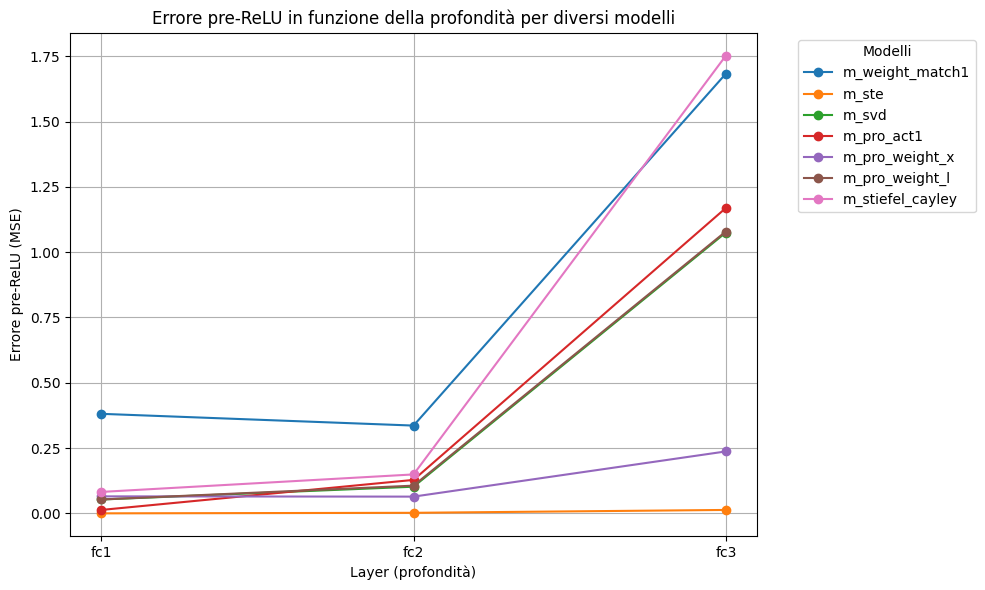

In [180]:
#@title Plot errore pre-ReLu in funzione della profondità
plt.figure(figsize=(10,6))

for i, model_name in enumerate(names):
    error_pre = pre[i]
    plt.plot(layer_names, error_pre, marker='o', label=model_name)

plt.xlabel('Layer (profondità)')
plt.ylabel('Errore pre-ReLU (MSE)')
plt.title('Errore pre-ReLU in funzione della profondità per diversi modelli')
plt.legend(title='Modelli', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Prendendo in considerazione lo studio condotto, si ritiene che le rotazioni costituiscono uno strumento valido nella ricerca dell'allineamento e della fusione di reti neurali con identica architettura.